# LLM/NLP Analysis of Cognitive States using ZuCo Dataset

## 1. **Project Setup and Initial Configuration**  
This section consolidates all imports, configurations, and initial data loading functions for streamlined analysis.

### 1.1. Import Necessary Libraries

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import glob
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # For tokenization

# --- Scikit-learn for Modeling & Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

# --- NLP & Feature Extraction Libraries ---
# Ensure these are installed:
# pip install sentence-transformers textstat spacy
# python -m spacy download en_core_web_sm
# pip install ollama (if using actual Ollama integration)
from sentence_transformers import SentenceTransformer
import textstat
import spacy
# import ollama # Uncomment if you plan to use direct Ollama integration

# --- Utility ---
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output (optional)

# --- Plotting Style ---
sns.set_style("whitegrid")

# --- Reproducibility ---
RANDOM_STATE = 42

# --- Download NLTK resources (if not already present) ---
try:
    nltk.data.find('tokenizers/punkt')
except (LookupError, OSError):
    nltk.download('punkt', quiet=True)
    
from nltk.tokenize import word_tokenize

### 1.2. Configuration Constants and File Paths

In [2]:
# --- Configuration Constants ---
DATA_DIRECTORY = "task_materials"  # Directory containing the CSV files
NR_FILE_PATTERN = "nr_*.csv"
TSR_FILE_PATTERN = "tsr_*.csv"
SENTENCE_COLUMN_INDEX = 2  # Sentences are in the 3rd column (0-indexed)

# --- Output Filenames for Processed Data & Features ---
# This helps in saving intermediate results and avoiding re-computation
PROCESSED_DATA_FILENAME = "zuco_processed_sentences.csv"
EMBEDDINGS_FILENAME_NP = "sentence_embeddings.npy"
BASE_DISCRETE_FEATURES_FILENAME_CSV = "base_discrete_features.csv"
ENHANCED_DISCRETE_FEATURES_FILENAME_CSV = "enhanced_discrete_features.csv"

# --- For Storing Model Results ---
all_model_results_list = [] # Initialize a list to store results from all models

### 1.3. Utility Functions

#### 1.3.1. Data Loading Function

In [3]:
def load_sentences_from_files(directory, file_pattern, condition_label):
    """
    Loads sentences from CSV files matching a pattern within a specified directory.

    Args:
        directory (str): The directory where CSV files are located.
        file_pattern (str): Glob pattern for the CSV files (e.g., "nr_*.csv").
        condition_label (str): Label to assign (e.g., "NR" or "TSR").

    Returns:
        pandas.DataFrame: DataFrame with 'sentence' and 'condition' columns,
                          or an empty DataFrame if no files are found or errors occur.
    """
    full_pattern = os.path.join(directory, file_pattern)
    filenames = sorted(glob.glob(full_pattern)) # Sort for consistent order

    if not filenames:
        print(f"No files found for pattern: {full_pattern}")
        print("Please ensure DATA_DIRECTORY and file patterns are correct.")
        return pd.DataFrame(columns=['sentence', 'condition']) # Return empty DataFrame

    all_sentences_dfs = []
    for filename in filenames:
        try:
            # Assuming sentences are in the column specified by SENTENCE_COLUMN_INDEX
            df = pd.read_csv(filename, delimiter=';', header=None, on_bad_lines='warn')
            if SENTENCE_COLUMN_INDEX < df.shape[1]:
                sentences_df = df.iloc[:, [SENTENCE_COLUMN_INDEX]].copy() # Use .copy()
                sentences_df.columns = ['sentence']
                sentences_df['condition'] = condition_label
                all_sentences_dfs.append(sentences_df)
            else:
                print(f"Warning: {filename} does not have column index {SENTENCE_COLUMN_INDEX}.")
        except pd.errors.EmptyDataError:
            print(f"Warning: {filename} is empty.")
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not all_sentences_dfs:
        print(f"No sentences extracted for condition: {condition_label}")
        return pd.DataFrame(columns=['sentence', 'condition'])

    return pd.concat(all_sentences_dfs, ignore_index=True)

#### 1.3.2. Text Cleaning Function

In [4]:
def clean_text(text):
    """
    Cleans a text string by converting to lowercase and removing extra whitespace.
    Handles potential non-string inputs by converting to string first.

    Args:
        text (any): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    text = str(text).lower() # Ensure text is string, then lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    # Consider other cleaning steps here if needed (e.g., removing specific punctuation, numbers)
    # For this project, keeping numbers like "[1]" as they might be relevant.
    return text

## 2. Data Loading, Initial EDA, and Preprocessing

### 2.1. Load Raw Sentence Data

In [5]:
print("--- 2.1. Loading Raw Sentence Data ---")
nr_sentences_df = load_sentences_from_files(DATA_DIRECTORY, NR_FILE_PATTERN, "NR")
tsr_sentences_df = load_sentences_from_files(DATA_DIRECTORY, TSR_FILE_PATTERN, "TSR")

combined_df = pd.DataFrame(columns=['sentence', 'condition']) # Initialize
if not nr_sentences_df.empty and not tsr_sentences_df.empty:
    combined_df = pd.concat([nr_sentences_df, tsr_sentences_df], ignore_index=True)
    print(f"Successfully loaded and combined NR and TSR sentences.")
    print(f"Shape of combined_df: {combined_df.shape}")
elif not nr_sentences_df.empty:
    combined_df = nr_sentences_df
    print("Warning: Only NR data was loaded.")
elif not tsr_sentences_df.empty:
    combined_df = tsr_sentences_df
    print("Warning: Only TSR data was loaded.")
else:
    print("Error: No data was loaded. Please check DATA_DIRECTORY and file patterns.")

if not combined_df.empty:
    combined_df['sentence'] = combined_df['sentence'].astype(str) # Ensure sentence column is string
    print("\nInitial combined_df head:")
    display(combined_df.head())
    print("\nCondition distribution:")
    print(combined_df['condition'].value_counts())
    print(f"\nNumber of missing sentences: {combined_df['sentence'].isnull().sum()}")
    print(f"Number of duplicate sentences (raw): {combined_df.duplicated(subset=['sentence']).sum()}")
else:
    print("Cannot proceed as combined_df is empty.")

--- 2.1. Loading Raw Sentence Data ---
Successfully loaded and combined NR and TSR sentences.
Shape of combined_df: (781, 2)

Initial combined_df head:


,sentence,condition
0,"Henry Ford (July 30, 1863 - April 7, 1947) was...",NR
1,"Henry Ford, with eleven other investors and $2...",NR
2,"On January 1, 1919, after unsuccessfully seeki...",NR
3,"Henry Ford, with his son Edsel, founded the Fo...",NR
4,"After this initial success, Ford left Edison I...",NR



Condition distribution:
condition
TSR    411
NR     370
Name: count, dtype: int64

Number of missing sentences: 0
Number of duplicate sentences (raw): 85


### 2.2. Basic Exploratory Data Analysis (EDA) - Sentence Lengths


--- 2.2. Basic Exploratory Data Analysis (Sentence Lengths) ---


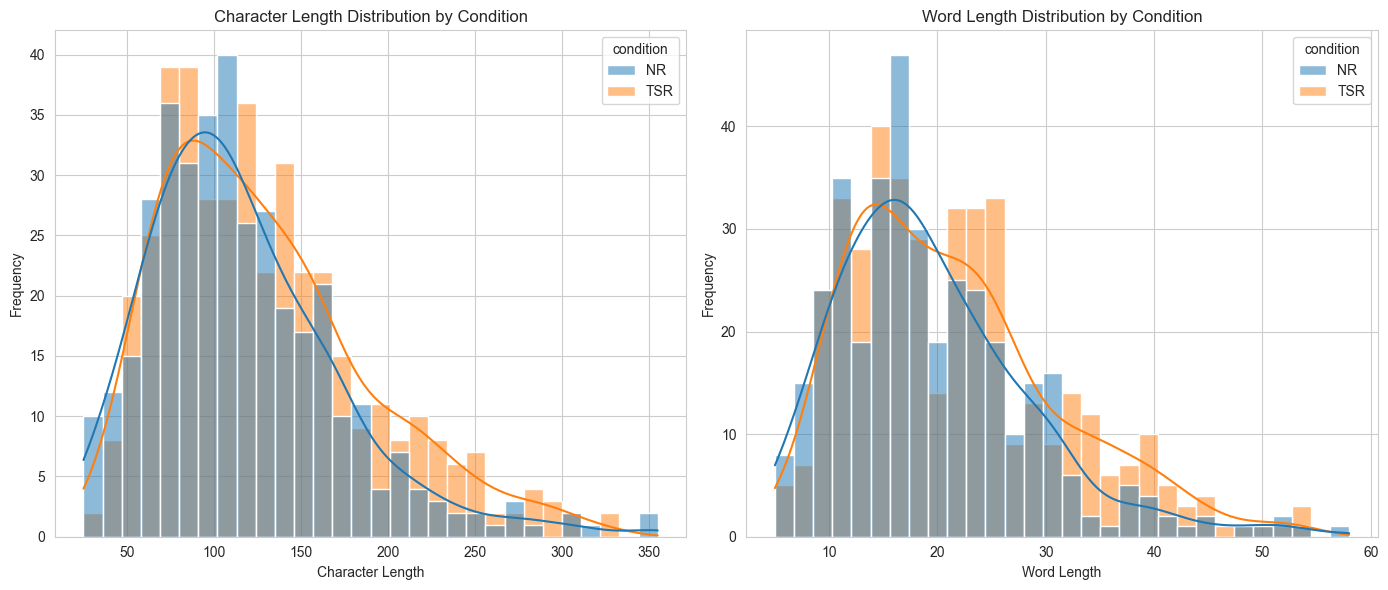

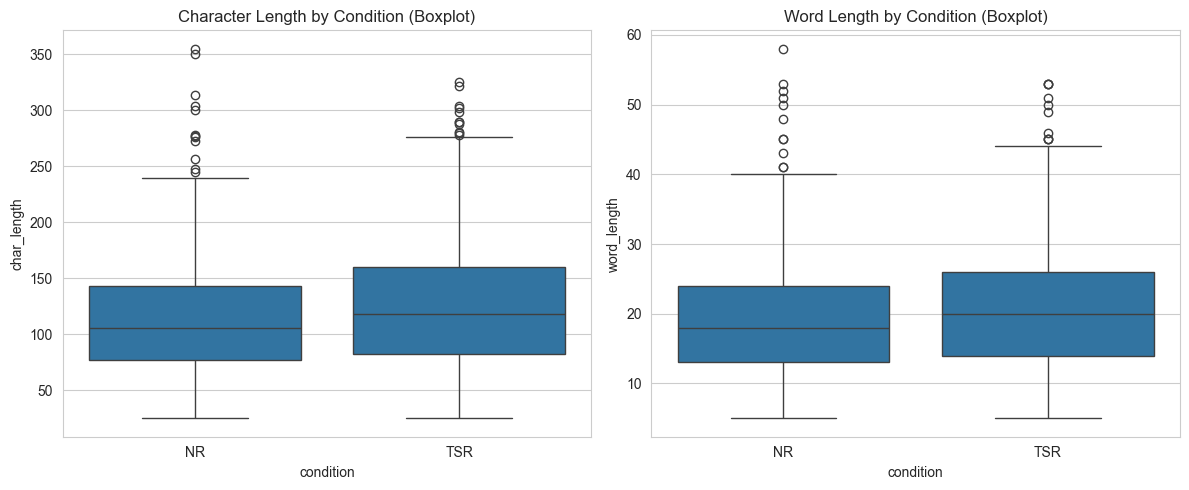


Descriptive Statistics for Sentence Lengths (Overall):
       char_length  word_length
count   781.000000   781.000000
mean    122.581306    20.501921
std      57.796572     9.388567
min      25.000000     5.000000
25%      80.000000    13.000000
50%     111.000000    19.000000
75%     154.000000    25.000000
max     355.000000    58.000000

Descriptive Statistics for Sentence Lengths (Grouped by Condition):
          char_length                                                     \
                count        mean        std   min    25%    50%     75%   
condition                                                                  
NR              370.0  115.994595  55.278011  25.0  77.25  106.0  142.75   
TSR             411.0  128.510949  59.418005  25.0  82.00  118.0  160.00   

                 word_length                                                    
             max       count       mean       std  min   25%   50%   75%   max  
condition                                   

In [6]:
if not combined_df.empty:
    print("\n--- 2.2. Basic Exploratory Data Analysis (Sentence Lengths) ---")
    combined_df['char_length'] = combined_df['sentence'].apply(len)
    combined_df['word_length'] = combined_df['sentence'].apply(lambda x: len(x.split())) # Simple word count

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=combined_df, x='char_length', hue='condition', kde=True, bins=30)
    plt.title('Character Length Distribution by Condition')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(data=combined_df, x='word_length', hue='condition', kde=True, bins=30)
    plt.title('Word Length Distribution by Condition')
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig("sentence_length_distributions.png") # Save the plot
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=combined_df, x='condition', y='char_length')
    plt.title('Character Length by Condition (Boxplot)')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=combined_df, x='condition', y='word_length')
    plt.title('Word Length by Condition (Boxplot)')
    plt.tight_layout()
    plt.savefig("sentence_length_boxplots.png") # Save the plot
    plt.show()

    print("\nDescriptive Statistics for Sentence Lengths (Overall):")
    print(combined_df[['char_length', 'word_length']].describe())
    print("\nDescriptive Statistics for Sentence Lengths (Grouped by Condition):")
    print(combined_df.groupby('condition')[['char_length', 'word_length']].describe())
else:
    print("Skipping EDA as combined_df is empty.")

### 2.3. Data Preprocessing: Unique Sentences, Cleaning, and Labeling

In [7]:
df_processed = pd.DataFrame() # Initialize

if not nr_sentences_df.empty and not tsr_sentences_df.empty:
    print("\n--- 2.3. Data Preprocessing ---")
    # Get unique sentences for each condition
    nr_unique_sentences_list = nr_sentences_df['sentence'].drop_duplicates().tolist()
    tsr_unique_sentences_list = tsr_sentences_df['sentence'].drop_duplicates().tolist()

    print(f"Number of unique NR sentences: {len(nr_unique_sentences_list)}")
    print(f"Number of unique TSR sentences: {len(tsr_unique_sentences_list)}")

    # Find sentences common to both unique lists
    common_sentences_set = set(nr_unique_sentences_list).intersection(set(tsr_unique_sentences_list))
    print(f"Number of sentences common to both unique NR and TSR lists: {len(common_sentences_set)}")

    # Create DataFrames with only unique sentences for each condition, excluding common ones
    df_nr_only = pd.DataFrame({
        'sentence': list(set(nr_unique_sentences_list) - common_sentences_set),
        'condition': 'NR'
    })
    df_tsr_only = pd.DataFrame({
        'sentence': list(set(tsr_unique_sentences_list) - common_sentences_set),
        'condition': 'TSR'
    })

    df_processed = pd.concat([df_nr_only, df_tsr_only], ignore_index=True)

    # Apply text cleaning
    df_processed['cleaned_sentence'] = df_processed['sentence'].apply(clean_text)

    # Remove duplicates that might have arisen *after* cleaning
    df_processed.drop_duplicates(subset=['cleaned_sentence'], keep='first', inplace=True)
    df_processed.reset_index(drop=True, inplace=True) # Reset index after dropping duplicates

    # Encode labels
    df_processed['label'] = df_processed['condition'].apply(lambda x: 0 if x == 'NR' else 1) # NR:0, TSR:1

    print(f"\nShape of the final processed dataset (df_processed): {df_processed.shape}")
    print("Distribution of conditions in the final processed dataset:")
    print(df_processed['label'].value_counts(normalize=True)) # Show normalized counts for balance

    # Save the processed DataFrame
    try:
        df_processed.to_csv(PROCESSED_DATA_FILENAME, index=False)
        print(f"\nProcessed dataset saved to: {PROCESSED_DATA_FILENAME}")
    except Exception as e:
        print(f"Error saving processed dataset: {e}")

else:
    print("Skipping preprocessing as NR or TSR data is missing or empty.")

# Display head of the final processed data
if not df_processed.empty:
    print("\nHead of df_processed:")
    display(df_processed.head())


--- 2.3. Data Preprocessing ---
Number of unique NR sentences: 365
Number of unique TSR sentences: 392
Number of sentences common to both unique NR and TSR lists: 61

Shape of the final processed dataset (df_processed): (635, 4)
Distribution of conditions in the final processed dataset:
label
1    0.52126
0    0.47874
Name: proportion, dtype: float64

Processed dataset saved to: zuco_processed_sentences.csv

Head of df_processed:


,sentence,condition,cleaned_sentence,label
0,"Through his son Timothy Bush, Jr., who was als...",NR,"through his son timothy bush, jr., who was als...",0
1,"Kerouac's spontaneous, confessional language s...",NR,"kerouac's spontaneous, confessional language s...",0
2,Lawford later admitted the most terrifying exp...,NR,lawford later admitted the most terrifying exp...,0
3,"They had four children: Frederick Dent Grant, ...",NR,"they had four children: frederick dent grant, ...",0
4,He received his bachelor's degree in 1965 and ...,NR,he received his bachelor's degree in 1965 and ...,0


## 3. Feature Engineering

### 3.1. Feature Engineering Strategy

**Strategy Overview:**
Two primary feature engineering strategies will be implemented, and their performance will be compared using the F1-score for the TSR class (label 1) as the main metric, alongside accuracy and macro F1-score.


**Option A: Sentence Embeddings (LLM-based)**
- **Approach**: Use a pre-trained sentence transformer (e.g., `all-MiniLM-L6-v2`) to generate dense vector representations.
- **Rationale**: Captures rich semantic and syntactic information, making it suitable for subtle distinctions in text.

**Option B: Discrete Linguistic Features & (Optionally) Locally-Generated LLM Metrics**
- **Extracted Features**:
    - **Basic Text Statistics**: Character length, word count, average word length.
    - **Lexical Features**: Type-Token Ratio (TTR), Lexical Density (proxy).
    - **Readability Scores**: Flesch Reading Ease, Flesch-Kincaid Grade, Gunning Fog Index (via `textstat`).
    - **Syntactic Complexity Features**: 
        - Number of subordinate/conjunctive clauses (simplified).
        - Average/max dependency distance.
        - POS tag counts (verbs, nouns, adjectives, adverbs, prepositions, conjunctions) using `spaCy`.
    - **(Experimental/Optional) Locally-Generated LLM Metrics**: 
        - Proxy for perplexity or prompt-based complexity rating (using `Ollama` with models like `llama3`).
        - Note: Computationally intensive with variable results.
- **Rationale**: Offers interpretability and highlights specific structural/lexical differences. Local LLM metrics explore model-perceived complexity.

### 3.2. Option A: Sentence Embeddings

In [8]:
# --- Option A: Sentence Embeddings ---
sentence_embeddings_array = np.array([]) # Initialize

# Try to load saved embeddings first
if os.path.exists(EMBEDDINGS_FILENAME_NP):
    print(f"--- 3.2.1. Loading saved sentence embeddings from {EMBEDDINGS_FILENAME_NP} ---")
    sentence_embeddings_array = np.load(EMBEDDINGS_FILENAME_NP)
    print(f"Loaded sentence embeddings. Shape: {sentence_embeddings_array.shape}")
    # Ensure the loaded embeddings match the current df_processed length
    if not df_processed.empty and sentence_embeddings_array.shape[0] != len(df_processed):
        print(f"Warning: Loaded embeddings shape {sentence_embeddings_array.shape} "
              f"does not match df_processed length {len(df_processed)}. Will regenerate.")
        sentence_embeddings_array = np.array([]) # Force regeneration
elif not df_processed.empty and 'cleaned_sentence' in df_processed.columns:
    print("\n--- 3.2.1. Generating Sentence Embeddings (Option A) ---")
    try:
        # Use a robust, freely available sentence transformer model
        embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu') # Specify CPU if GPU issues
        sentences_to_embed = df_processed['cleaned_sentence'].tolist()

        if not any(s.strip() for s in sentences_to_embed): # Check if all sentences are empty/whitespace
            print("Warning: No valid sentences to embed for Option A.")
        else:
            print(f"Embedding {len(sentences_to_embed)} sentences...")
            sentence_embeddings_array = embedding_model.encode(sentences_to_embed, show_progress_bar=True)
            print(f"Shape of generated sentence embeddings: {sentence_embeddings_array.shape}")
            # Save the generated embeddings
            try:
                np.save(EMBEDDINGS_FILENAME_NP, sentence_embeddings_array)
                print(f"Sentence embeddings saved to: {EMBEDDINGS_FILENAME_NP}")
            except Exception as e:
                print(f"Error saving sentence embeddings: {e}")
    except Exception as e:
        print(f"Error generating sentence embeddings: {e}")
else:
    print("Skipping Option A (Sentence Embeddings) as processed data is unavailable.")

if sentence_embeddings_array.size == 0 and not df_processed.empty:
     print("Warning: Sentence embeddings array is empty. Subsequent steps using embeddings might fail.")
elif not df_processed.empty and sentence_embeddings_array.shape[0] != len(df_processed):
    print(f"Critical Error: Embeddings shape {sentence_embeddings_array.shape} does not match df_processed length {len(df_processed)} even after attempting regeneration.")

--- 3.2.1. Loading saved sentence embeddings from sentence_embeddings.npy ---
Loaded sentence embeddings. Shape: (635, 384)


### 3.3. Option B: Discrete Linguistic Features

#### 3.3.1. Base Discrete Features (Text Stats, Lexical, Readability)

In [9]:
df_base_discrete_features = pd.DataFrame() # Initialize

# Try to load saved base discrete features first
if os.path.exists(BASE_DISCRETE_FEATURES_FILENAME_CSV):
    print(f"\n--- 3.3.1. Loading saved base discrete features from {BASE_DISCRETE_FEATURES_FILENAME_CSV} ---")
    df_base_discrete_features = pd.read_csv(BASE_DISCRETE_FEATURES_FILENAME_CSV)
    print(f"Loaded base discrete features. Shape: {df_base_discrete_features.shape}")
    if not df_processed.empty and len(df_base_discrete_features) != len(df_processed):
        print(f"Warning: Loaded base discrete features length {len(df_base_discrete_features)} "
              f"does not match df_processed length {len(df_processed)}. Will regenerate.")
        df_base_discrete_features = pd.DataFrame() # Force regeneration
elif not df_processed.empty and 'cleaned_sentence' in df_processed.columns:
    print("\n--- 3.3.1. Generating Base Discrete Linguistic Features (Option B) ---")
    df_base_discrete_features = pd.DataFrame(index=df_processed.index) # Align with df_processed

    # 1. Basic Text Statistics
    df_base_discrete_features['char_count'] = df_processed['cleaned_sentence'].apply(len)
    df_base_discrete_features['word_count'] = df_processed['cleaned_sentence'].apply(lambda x: len(x.split()))
    # Avoid division by zero for avg_word_length
    df_base_discrete_features['avg_word_length'] = df_base_discrete_features['char_count'] / \
                                              df_base_discrete_features['word_count'].replace(0, np.nan) # Use NaN for 0 words

    # 2. Lexical Features
    def type_token_ratio(text):
        tokens = word_tokenize(text) # Using nltk.word_tokenize for better tokenization
        return len(set(tokens)) / len(tokens) if tokens else 0
    df_base_discrete_features['ttr'] = df_processed['cleaned_sentence'].apply(type_token_ratio)

    def lexical_density_proxy(text):
        tokens = word_tokenize(text)
        # Basic proxy: ratio of words longer than 6 chars (often content words)
        return sum(1 for word in tokens if len(word) > 6) / len(tokens) if tokens else 0
    df_base_discrete_features['lex_density_proxy'] = df_processed['cleaned_sentence'].apply(lexical_density_proxy)

    # 3. Readability Scores (using textstat)
    def get_safe_readability_score(text, func, default_val=0.0):
        """Safely computes readability score, handling empty or very short texts."""
        if text and len(text.split()) > 5: # textstat might need a minimum number of words
            try:
                return float(func(text))
            except: # Catch any error from textstat
                return float(default_val)
        return float(default_val)

    df_base_discrete_features['flesch_ease'] = df_processed['cleaned_sentence'].apply(
        lambda x: get_safe_readability_score(x, textstat.flesch_reading_ease, default_val=200.0)) # Higher is easier
    df_base_discrete_features['flesch_grade'] = df_processed['cleaned_sentence'].apply(
        lambda x: get_safe_readability_score(x, textstat.flesch_kincaid_grade, default_val=20.0)) # Higher is harder
    df_base_discrete_features['gunning_fog'] = df_processed['cleaned_sentence'].apply(
        lambda x: get_safe_readability_score(x, textstat.gunning_fog, default_val=20.0)) # Higher is harder

    # Handle potential NaN/inf values robustly (e.g., from avg_word_length if word_count was 0)
    df_base_discrete_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Impute NaNs - using median is often more robust to outliers than mean for these types of features
    for col in df_base_discrete_features.columns:
        if df_base_discrete_features[col].isnull().any():
            df_base_discrete_features[col].fillna(df_base_discrete_features[col].median(), inplace=True)
    df_base_discrete_features.fillna(0, inplace=True) # Catch-all for any remaining NaNs (e.g., if all values were NaN)

    print(f"Base discrete linguistic features generated. Shape: {df_base_discrete_features.shape}")
    try:
        df_base_discrete_features.to_csv(BASE_DISCRETE_FEATURES_FILENAME_CSV, index=False)
        print(f"Base discrete features saved to: {BASE_DISCRETE_FEATURES_FILENAME_CSV}")
    except Exception as e:
        print(f"Error saving base discrete features: {e}")
else:
    print("Skipping Base Discrete Feature extraction as processed data is unavailable.")

if not df_base_discrete_features.empty:
    print("\nHead of df_base_discrete_features:")
    display(df_base_discrete_features.head())
    print("\nDescription of df_base_discrete_features:")
    display(df_base_discrete_features.describe())


--- 3.3.1. Loading saved base discrete features from base_discrete_features.csv ---
Loaded base discrete features. Shape: (635, 8)

Head of df_base_discrete_features:


,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog
0,168,27,6.222222,0.833333,0.266667,32.163333,15.480741,18.207407
1,126,22,5.727273,0.892857,0.250000,34.532273,13.908182,17.890909
2,157,25,6.280000,0.925926,0.259259,46.100000,13.040000,19.600000
3,195,31,6.290323,0.857143,0.285714,36.189355,15.912903,16.270968
4,90,16,5.625000,0.894737,0.210526,68.982500,7.612500,6.400000



Description of df_base_discrete_features:


,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,126.548031,21.064567,6.001506,0.899012,0.229864,48.454158,11.554996,13.729521
std,59.507883,9.671118,0.597952,0.083112,0.085461,24.074463,4.468520,5.101659
min,27.000000,5.000000,4.285714,0.614035,0.000000,-27.900000,-1.060000,2.200000
25%,82.500000,14.000000,5.600000,0.848155,0.173163,33.465000,8.544545,10.000000
50%,116.000000,20.000000,5.973684,0.909091,0.230769,47.455000,11.169412,13.866667
75%,159.000000,26.000000,6.388889,0.956522,0.285714,61.998696,14.371803,16.914286
max,355.000000,58.000000,8.888889,1.000000,0.555556,200.000000,27.374828,30.596078


#### 3.3.2. Enhanced Discrete Features (Syntactic with spaCy)

In [10]:
df_enhanced_discrete_features = pd.DataFrame() # Initialize

# Try to load saved enhanced discrete features first
if os.path.exists(ENHANCED_DISCRETE_FEATURES_FILENAME_CSV):
    print(f"\n--- 3.3.2. Loading saved ENHANCED discrete features from {ENHANCED_DISCRETE_FEATURES_FILENAME_CSV} ---")
    df_enhanced_discrete_features = pd.read_csv(ENHANCED_DISCRETE_FEATURES_FILENAME_CSV)
    print(f"Loaded ENHANCED discrete features. Shape: {df_enhanced_discrete_features.shape}")
    if not df_processed.empty and len(df_enhanced_discrete_features) != len(df_processed):
        print(f"Warning: Loaded ENHANCED discrete features length {len(df_enhanced_discrete_features)} "
              f"does not match df_processed length {len(df_processed)}. Will regenerate if base exists.")
        df_enhanced_discrete_features = pd.DataFrame() # Force regeneration path if base exists
elif not df_base_discrete_features.empty and not df_processed.empty: # Regenerate if base exists but enhanced doesn't
    print("\n--- 3.3.2. Generating ENHANCED Discrete Features (adding spaCy Syntactic) ---")
    df_enhanced_discrete_features = df_base_discrete_features.copy() # Start with base features

    try:
        # Load spaCy model (small English model)
        # Disable unnecessary components for speed if only using parser/tagger
        nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])
        print("spaCy model 'en_core_web_sm' loaded successfully.")

        syntactic_features_list = []
        # Process texts in batches using nlp.pipe for efficiency
        print(f"Extracting syntactic features for {len(df_processed)} sentences using spaCy...")
        for doc in nlp.pipe(df_processed['cleaned_sentence'].fillna('').tolist(), batch_size=50):
            if not doc or len(doc) == 0: # Handle empty docs after fillna('')
                features = {
                    'num_subord_clauses': 0, 'num_conj_clauses': 0, 'avg_dep_dist': 0.0,
                    'max_dep_dist': 0, 'num_verbs': 0, 'num_nouns': 0, 'num_adjectives': 0,
                    'num_adverbs': 0, 'num_prepositions': 0, 'num_conjunctions': 0
                }
            else:
                # Simplified clause counting
                num_sconj = sum(1 for token in doc if token.dep_ == 'mark') # Subordinating conjunctions often mark subordinate clauses
                num_cconj = sum(1 for token in doc if token.dep_ == 'cc' and token.head.pos_ == 'VERB') # Conjunctions joining verb phrases

                dep_distances = [abs(token.i - token.head.i) for token in doc if token.head is not token]

                pos_counts = doc.count_by(spacy.attrs.POS)
                num_verbs = pos_counts.get(spacy.parts_of_speech.VERB, 0)
                num_nouns = pos_counts.get(spacy.parts_of_speech.NOUN, 0) + pos_counts.get(spacy.parts_of_speech.PROPN, 0)
                num_adjectives = pos_counts.get(spacy.parts_of_speech.ADJ, 0)
                num_adverbs = pos_counts.get(spacy.parts_of_speech.ADV, 0)
                num_prepositions = pos_counts.get(spacy.parts_of_speech.ADP, 0) # Adpositions
                num_conjunctions = pos_counts.get(spacy.parts_of_speech.CCONJ, 0) + pos_counts.get(spacy.parts_of_speech.SCONJ, 0)

                features = {
                    'num_subord_clauses': num_sconj,
                    'num_conj_clauses': num_cconj,
                    'avg_dep_dist': np.mean(dep_distances) if dep_distances else 0.0,
                    'max_dep_dist': np.max(dep_distances) if dep_distances else 0,
                    'num_verbs': num_verbs,
                    'num_nouns': num_nouns,
                    'num_adjectives': num_adjectives,
                    'num_adverbs': num_adverbs,
                    'num_prepositions': num_prepositions,
                    'num_conjunctions': num_conjunctions
                }
            syntactic_features_list.append(features)

        df_spacy_features = pd.DataFrame(syntactic_features_list, index=df_processed.index)
        df_enhanced_discrete_features = pd.concat([df_enhanced_discrete_features, df_spacy_features], axis=1)

        # Clean up NaNs/Infs again after adding new features
        df_enhanced_discrete_features.replace([np.inf, -np.inf], np.nan, inplace=True)
        for col in df_spacy_features.columns: # Only impute newly added columns if needed
            if df_enhanced_discrete_features[col].isnull().any():
                 df_enhanced_discrete_features[col].fillna(df_enhanced_discrete_features[col].median(), inplace=True)
        df_enhanced_discrete_features.fillna(0, inplace=True)

        print(f"spaCy syntactic features added. Shape of df_enhanced_discrete_features: {df_enhanced_discrete_features.shape}")
        try:
            df_enhanced_discrete_features.to_csv(ENHANCED_DISCRETE_FEATURES_FILENAME_CSV, index=False)
            print(f"Enhanced discrete features saved to: {ENHANCED_DISCRETE_FEATURES_FILENAME_CSV}")
        except Exception as e:
            print(f"Error saving ENHANCED discrete features: {e}")

    except OSError:
        print("spaCy model 'en_core_web_sm' not found. Please download it: python -m spacy download en_core_web_sm")
        print("Skipping spaCy feature enhancement.")
        df_enhanced_discrete_features = df_base_discrete_features.copy() # Fallback to base features
    except Exception as e:
        print(f"An error occurred during spaCy feature extraction: {e}")
        df_enhanced_discrete_features = df_base_discrete_features.copy() # Fallback
else:
     print("Skipping ENHANCED Discrete Feature generation (spaCy) as base discrete features or processed data is unavailable.")


if not df_enhanced_discrete_features.empty:
    print("\nHead of df_enhanced_discrete_features:")
    display(df_enhanced_discrete_features.head())
    print("\nDescription of df_enhanced_discrete_features:")
    display(df_enhanced_discrete_features.describe())


--- 3.3.2. Loading saved ENHANCED discrete features from enhanced_discrete_features.csv ---
Loaded ENHANCED discrete features. Shape: (635, 18)

Head of df_enhanced_discrete_features:


,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog,num_subord_clauses,num_conj_clauses,avg_dep_dist,max_dep_dist,num_verbs,num_nouns,num_adjectives,num_adverbs,num_prepositions,num_conjunctions
0,168,27,6.222222,0.833333,0.266667,32.163333,15.480741,18.207407,1,0,2.933333,22,3,9,2,1,3,4
1,126,22,5.727273,0.892857,0.250000,34.532273,13.908182,17.890909,0,0,2.607143,13,3,8,1,2,4,0
2,157,25,6.280000,0.925926,0.259259,46.100000,13.040000,19.600000,0,0,3.129032,28,4,8,1,0,5,0
3,195,31,6.290323,0.857143,0.285714,36.189355,15.912903,16.270968,0,0,2.742857,31,4,13,0,0,6,1
4,90,16,5.625000,0.894737,0.210526,68.982500,7.612500,6.400000,0,0,2.736842,15,2,8,0,0,1,1



Description of df_enhanced_discrete_features:


,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog,num_subord_clauses,num_conj_clauses,avg_dep_dist,max_dep_dist,num_verbs,num_nouns,num_adjectives,num_adverbs,num_prepositions,num_conjunctions
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,126.548031,21.064567,6.001506,0.899012,0.229864,48.454158,11.554996,13.729521,0.124409,0.261417,3.037494,17.938583,1.929134,7.870866,1.552756,0.573228,2.891339,0.979528
std,59.507883,9.671118,0.597952,0.083112,0.085461,24.074463,4.468520,5.101659,0.379215,0.506433,0.732921,9.858510,1.399533,4.428081,1.420325,0.869520,2.117042,0.948795
min,27.000000,5.000000,4.285714,0.614035,0.000000,-27.900000,-1.060000,2.200000,0.000000,0.000000,1.333333,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.500000,14.000000,5.600000,0.848155,0.173163,33.465000,8.544545,10.000000,0.000000,0.000000,2.525063,11.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000
50%,116.000000,20.000000,5.973684,0.909091,0.230769,47.455000,11.169412,13.866667,0.000000,0.000000,2.942857,15.000000,2.000000,7.000000,1.000000,0.000000,3.000000,1.000000
75%,159.000000,26.000000,6.388889,0.956522,0.285714,61.998696,14.371803,16.914286,0.000000,0.000000,3.450957,22.000000,3.000000,10.500000,2.000000,1.000000,4.000000,2.000000
max,355.000000,58.000000,8.888889,1.000000,0.555556,200.000000,27.374828,30.596078,3.000000,3.000000,6.711864,61.000000,9.000000,25.000000,8.000000,7.000000,13.000000,4.000000


#### 3.3.3. (Experimental) Locally-Generated LLM Metrics via Ollama

In [11]:
# --- (Experimental) Locally-Generated LLM Metrics (Ollama) ---
# This section is experimental and can be VERY time-consuming.
# Ensure Ollama server is running and the model (e.g., 'llama3') is pulled.

OLLAMA_ENABLED = True # Set to True to run actual Ollama calls (VERY SLOW)
OLLAMA_MODEL_NAME = 'llama3.2' # Or your specific Ollama model, e.g., 'llama3:8b'

if 'df_enhanced_discrete_features' not in globals(): # Ensure previous df exists
    df_enhanced_discrete_features = df_base_discrete_features.copy() if 'df_base_discrete_features' in globals() and not df_base_discrete_features.empty else pd.DataFrame()

if OLLAMA_ENABLED and not df_processed.empty and not df_enhanced_discrete_features.empty and \
   df_processed.shape[0] == df_enhanced_discrete_features.shape[0]:
    print(f"\n--- 3.3.3. Generating LLM-based Complexity Rating via Ollama (Experimental, Model: {OLLAMA_MODEL_NAME}) ---")

    def get_ollama_complexity_rating_prompt(sentence_text, model_name=OLLAMA_MODEL_NAME):
        if not sentence_text or not sentence_text.strip():
            return np.nan
        # Refined prompt for a more constrained, numerical output
        prompt_template = (
            f"Rate the complexity of the following English sentence on a scale of 1 (very simple) "
            f"to 5 (very complex). Respond with ONLY the integer number (1, 2, 3, 4, or 5) and nothing else.\n"
            f"Sentence: \"{sentence_text}\"\n"
            f"Rating:"
        )
        try:
            response = ollama.generate(
                model=model_name,
                prompt=prompt_template,
                stream=False,
                options={"temperature": 0.1, "num_predict": 3} # Low temp for consistency, limit output
            )
            rating_text = response['response'].strip()
            # Try to extract the first integer found in the response
            match = re.search(r'\b([1-5])\b', rating_text) # Look for a single digit 1-5
            if match:
                return int(match.group(0))
            else:
                # print(f"Warning: Could not parse valid rating (1-5) from Ollama response: '{rating_text}' for sentence: '{sentence_text[:30]}...'")
                return np.nan # Return NaN if parsing fails
        except Exception as e:
            # print(f"Error with Ollama for sentence '{sentence_text[:30]}...': {e}")
            return np.nan

    llm_complexity_ratings = []
    sentences_for_llm_rating = df_processed['cleaned_sentence'].fillna('').tolist()

    print(f"Attempting to generate LLM complexity ratings for {len(sentences_for_llm_rating)} sentences.")
    print("This can be extremely time-consuming. Consider running on a small subset first.")
    for i, sentence in enumerate(sentences_for_llm_rating): # UNCOMMENT FOR ACTUAL RUN
        if (i + 1) % 50 == 0:
            print(f"Processing sentence {i + 1}/{len(sentences_for_llm_rating)} for LLM rating...")
        rating = get_ollama_complexity_rating_prompt(sentence)
        llm_complexity_ratings.append(rating)
        time.sleep(0.2) # Be nice to the local server

    # --- SIMULATION BLOCK (Remove or comment out for actual Ollama calls) ---
    print("USING SIMULATED OLLAMA RATINGS FOR SPEED. Comment out this block for actual Ollama calls.")
    np.random.seed(RANDOM_STATE)
    llm_complexity_ratings = np.random.randint(1, 6, size=len(sentences_for_llm_rating)).astype(float)
    nan_indices_sim = np.random.choice(len(llm_complexity_ratings), size=int(0.05 * len(llm_complexity_ratings)), replace=False)
    llm_complexity_ratings[nan_indices_sim] = np.nan
    # --- END SIMULATION BLOCK ---

    df_enhanced_discrete_features['ollama_llm_rating'] = llm_complexity_ratings
    # Impute NaNs from errors or simulation
    median_llm_rating = df_enhanced_discrete_features['ollama_llm_rating'].median()
    if pd.isna(median_llm_rating): median_llm_rating = 3.0 # Default if all are NaN
    df_enhanced_discrete_features['ollama_llm_rating'].fillna(median_llm_rating, inplace=True)
    print("'ollama_llm_rating' feature processed and NaNs imputed.")

    # Save the dataframe again if Ollama features were actually generated and added
    if OLLAMA_ENABLED: # Only save if actual calls were made
        try:
            df_enhanced_discrete_features.to_csv(ENHANCED_DISCRETE_FEATURES_FILENAME_CSV, index=False)
            print(f"Enhanced discrete features (with Ollama ratings) saved to: {ENHANCED_DISCRETE_FEATURES_FILENAME_CSV}")
        except Exception as e:
            print(f"Error saving enhanced discrete features with Ollama ratings: {e}")

elif not OLLAMA_ENABLED:
    print("Ollama LLM rating generation was SKIPPED (OLLAMA_ENABLED=False).")
    # If df_enhanced_discrete_features exists and ollama_llm_rating is not already there from a previous run,
    # we might add a simulated column just so the subsequent code doesn't break if it expects it.
    if 'df_enhanced_discrete_features' in globals() and not df_enhanced_discrete_features.empty and \
       'ollama_llm_rating' not in df_enhanced_discrete_features.columns:
        print("Adding SIMULATED 'ollama_llm_rating' column as Ollama was disabled.")
        np.random.seed(RANDOM_STATE)
        sim_ratings = np.random.randint(1, 6, size=len(df_enhanced_discrete_features)).astype(float)
        df_enhanced_discrete_features['ollama_llm_rating'] = sim_ratings

else:
    print("Skipping Ollama LLM rating generation as base data is unavailable or misaligned.")

if not df_enhanced_discrete_features.empty:
    print("\nHead of df_enhanced_discrete_features (potentially with Ollama rating):")
    display(df_enhanced_discrete_features.head())
    print("\nDescription of df_enhanced_discrete_features (potentially with Ollama rating):")
    display(df_enhanced_discrete_features.describe())


--- 3.3.3. Generating LLM-based Complexity Rating via Ollama (Experimental, Model: llama3.2) ---
Attempting to generate LLM complexity ratings for 635 sentences.
This can be extremely time-consuming. Consider running on a small subset first.
Processing sentence 50/635 for LLM rating...
Processing sentence 100/635 for LLM rating...
Processing sentence 150/635 for LLM rating...
Processing sentence 200/635 for LLM rating...
Processing sentence 250/635 for LLM rating...
Processing sentence 300/635 for LLM rating...
Processing sentence 350/635 for LLM rating...
Processing sentence 400/635 for LLM rating...
Processing sentence 450/635 for LLM rating...
Processing sentence 500/635 for LLM rating...
Processing sentence 550/635 for LLM rating...
Processing sentence 600/635 for LLM rating...
USING SIMULATED OLLAMA RATINGS FOR SPEED. Comment out this block for actual Ollama calls.
'ollama_llm_rating' feature processed and NaNs imputed.
Enhanced discrete features (with Ollama ratings) saved to: e

,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog,num_subord_clauses,num_conj_clauses,avg_dep_dist,max_dep_dist,num_verbs,num_nouns,num_adjectives,num_adverbs,num_prepositions,num_conjunctions,ollama_llm_rating
0,168,27,6.222222,0.833333,0.266667,32.163333,15.480741,18.207407,1,0,2.933333,22,3,9,2,1,3,4,4.0
1,126,22,5.727273,0.892857,0.250000,34.532273,13.908182,17.890909,0,0,2.607143,13,3,8,1,2,4,0,5.0
2,157,25,6.280000,0.925926,0.259259,46.100000,13.040000,19.600000,0,0,3.129032,28,4,8,1,0,5,0,3.0
3,195,31,6.290323,0.857143,0.285714,36.189355,15.912903,16.270968,0,0,2.742857,31,4,13,0,0,6,1,5.0
4,90,16,5.625000,0.894737,0.210526,68.982500,7.612500,6.400000,0,0,2.736842,15,2,8,0,0,1,1,5.0



Description of df_enhanced_discrete_features (potentially with Ollama rating):


,char_count,word_count,avg_word_length,ttr,lex_density_proxy,flesch_ease,flesch_grade,gunning_fog,num_subord_clauses,num_conj_clauses,avg_dep_dist,max_dep_dist,num_verbs,num_nouns,num_adjectives,num_adverbs,num_prepositions,num_conjunctions,ollama_llm_rating
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,126.548031,21.064567,6.001506,0.899012,0.229864,48.454158,11.554996,13.729521,0.124409,0.261417,3.037494,17.938583,1.929134,7.870866,1.552756,0.573228,2.891339,0.979528,3.017323
std,59.507883,9.671118,0.597952,0.083112,0.085461,24.074463,4.468520,5.101659,0.379215,0.506433,0.732921,9.858510,1.399533,4.428081,1.420325,0.869520,2.117042,0.948795,1.391054
min,27.000000,5.000000,4.285714,0.614035,0.000000,-27.900000,-1.060000,2.200000,0.000000,0.000000,1.333333,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,82.500000,14.000000,5.600000,0.848155,0.173163,33.465000,8.544545,10.000000,0.000000,0.000000,2.525063,11.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,2.000000
50%,116.000000,20.000000,5.973684,0.909091,0.230769,47.455000,11.169412,13.866667,0.000000,0.000000,2.942857,15.000000,2.000000,7.000000,1.000000,0.000000,3.000000,1.000000,3.000000
75%,159.000000,26.000000,6.388889,0.956522,0.285714,61.998696,14.371803,16.914286,0.000000,0.000000,3.450957,22.000000,3.000000,10.500000,2.000000,1.000000,4.000000,2.000000,4.000000
max,355.000000,58.000000,8.888889,1.000000,0.555556,200.000000,27.374828,30.596078,3.000000,3.000000,6.711864,61.000000,9.000000,25.000000,8.000000,7.000000,13.000000,4.000000,5.000000


## 4. Model Training, Evaluation, and Comparison

#### 4.1 Helper Functions for Model Training and Evaluation

In [12]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test,
                             model_instance, model_class_name, feature_set_name):
    """
    Trains and evaluates a given scikit-learn model instance.

    Args:
        X_train, y_train, X_test, y_test: Training and testing data.
        model_instance: An instance of a scikit-learn classifier.
        model_class_name (str): Name of the model class (e.g., "LogisticRegression").
        feature_set_name (str): Name of the feature set used (e.g., "Embeddings").

    Returns:
        tuple: (trained_model, results_dict)
    """
    global all_model_results_list # Use the global list to store results

    model_full_name = f"{model_class_name} on {feature_set_name}"

    if X_train is None or X_test is None or y_train is None or y_test is None or \
       (isinstance(X_train, np.ndarray) and X_train.size == 0) or \
       (isinstance(X_train, pd.DataFrame) and X_train.empty):
        print(f"Skipping training for {model_full_name} as data is unavailable or empty.")
        return None, {}

    print(f"\n--- Training and Evaluating: {model_full_name} ---")
    model = model_instance # Use the passed instance

    start_time_train = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"ERROR during training {model_full_name}: {e}")
        return None, {}
    training_time = time.time() - start_time_train

    start_time_pred = time.time()
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"ERROR during prediction with {model_full_name}: {e}")
        return model, {} # Return the trained model but empty results for prediction part
    prediction_time = time.time() - start_time_pred

    print(f"Training time: {training_time:.3f}s | Prediction time: {prediction_time:.3f}s")
    print("\nClassification Report:")
    try:
        report_str = classification_report(y_test, y_pred, target_names=['NR (0)', 'TSR (1)'], zero_division=0)
        report_dict = classification_report(y_test, y_pred, target_names=['NR (0)', 'TSR (1)'], output_dict=True, zero_division=0)
        print(report_str)
    except Exception as e:
        print(f"Error generating classification report for {model_full_name}: {e}")
        report_dict = {}


    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    accuracy = accuracy_score(y_test, y_pred)
    f1_tsr = f1_score(y_test, y_pred, pos_label=1, zero_division=0) # TSR is class 1
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1-score (TSR class): {f1_tsr:.4f}")
    print(f"F1-score (Macro): {f1_macro:.4f}")
    print(f"F1-score (Weighted): {f1_weighted:.4f}")

    results = {
        "model_name": model_full_name,
        "model_class": model_class_name,
        "feature_set": feature_set_name,
        "accuracy": accuracy,
        "f1_score_TSR": f1_tsr,
        "f1_score_macro": f1_macro,
        "f1_score_weighted": f1_weighted,
        "classification_report_dict": report_dict,
        "confusion_matrix": cm.tolist(),
        "training_time_seconds": training_time,
        "prediction_time_seconds": prediction_time
    }
    all_model_results_list.append(results)
    return model, results

#### 4.2 Prepare Data Splits for Modeling

In [13]:
# Ensure df_processed is loaded and has the 'label' column
labels_array = np.array([])
if not df_processed.empty and 'label' in df_processed.columns:
    labels_array = df_processed['label'].values
    print(f"--- 4.2. Preparing Data Splits (Total samples: {len(labels_array)}) ---")
else:
    print("Error: Labels ('label' column in df_processed) not found. Cannot proceed with data splitting.")

# Option A: Sentence Embeddings
X_emb_train, X_emb_test, y_emb_train, y_emb_test = [None]*4 # Initialize
if sentence_embeddings_array.size > 0 and labels_array.size > 0:
    if sentence_embeddings_array.shape[0] == len(labels_array):
        X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(
            sentence_embeddings_array, labels_array, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array
        )
        print(f"Data split for Option A (Embeddings): Train {X_emb_train.shape}, Test {X_emb_test.shape}")
    else:
        print("Error: Mismatch between number of embeddings and labels for Option A.")
else:
    print("Skipping data split for Option A: Embeddings or labels are unavailable/empty.")


# Option B: Base Discrete Features (df_base_discrete_features)
X_base_disc_train_scaled, X_base_disc_test_scaled = [None]*2
X_base_disc_train_unscaled_df, X_base_disc_test_unscaled_df = [None]*2
y_base_disc_train, y_base_disc_test = [None]*2

if not df_base_discrete_features.empty and labels_array.size > 0:
    if len(df_base_discrete_features) == len(labels_array):
        X_base_disc_train_unscaled_df, X_base_disc_test_unscaled_df, \
        y_base_disc_train, y_base_disc_test = train_test_split(
            df_base_discrete_features, labels_array, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array
        )
        scaler_base_disc = StandardScaler()
        X_base_disc_train_scaled = scaler_base_disc.fit_transform(X_base_disc_train_unscaled_df)
        X_base_disc_test_scaled = scaler_base_disc.transform(X_base_disc_test_unscaled_df)
        print(f"Data split for Option B (Base Discrete): Train Scaled {X_base_disc_train_scaled.shape}, Test Scaled {X_base_disc_test_scaled.shape}")
    else:
        print("Error: Mismatch between number of base discrete features and labels for Option B.")
else:
    print("Skipping data split for Option B (Base Discrete): Features or labels are unavailable/empty.")


# Option B Enhanced: Enhanced Discrete Features (df_enhanced_discrete_features)
X_enh_disc_train_scaled, X_enh_disc_test_scaled = [None]*2
X_enh_disc_train_unscaled_df, X_enh_disc_test_unscaled_df = [None]*2
y_enh_disc_train, y_enh_disc_test = [None]*2

if not df_enhanced_discrete_features.empty and labels_array.size > 0:
    if len(df_enhanced_discrete_features) == len(labels_array):
        X_enh_disc_train_unscaled_df, X_enh_disc_test_unscaled_df, \
        y_enh_disc_train, y_enh_disc_test = train_test_split(
            df_enhanced_discrete_features, labels_array, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array
        )
        scaler_enh_disc = StandardScaler()
        X_enh_disc_train_scaled = scaler_enh_disc.fit_transform(X_enh_disc_train_unscaled_df)
        X_enh_disc_test_scaled = scaler_enh_disc.transform(X_enh_disc_test_unscaled_df)
        print(f"Data split for Option B (Enhanced Discrete): Train Scaled {X_enh_disc_train_scaled.shape}, Test Scaled {X_enh_disc_test_scaled.shape}")
    else:
         print("Error: Mismatch between number of enhanced discrete features and labels for Option B (Enhanced).")
else:
    print("Skipping data split for Option B (Enhanced Discrete): Features or labels are unavailable/empty.")


# Combined Features (Embeddings + Scaled Enhanced Discrete)
X_combined_train, X_combined_test = [None]*2
y_combined_train, y_combined_test = (y_emb_train, y_emb_test) if y_emb_train is not None else (y_enh_disc_train, y_enh_disc_test) # Use available y_train/test

if X_emb_train is not None and X_enh_disc_train_scaled is not None:
    if X_emb_train.shape[0] == X_enh_disc_train_scaled.shape[0]: # Ensure row counts match
        X_combined_train = np.concatenate((X_emb_train, X_enh_disc_train_scaled), axis=1)
        X_combined_test = np.concatenate((X_emb_test, X_enh_disc_test_scaled), axis=1)
        print(f"Data split for Combined Features: Train {X_combined_train.shape}, Test {X_combined_test.shape}")
    else:
        print("Error: Mismatch in sample numbers between embedding and scaled enhanced discrete feature sets for training. Cannot combine.")
else:
    print("Skipping data split for Combined Features: Embeddings or scaled enhanced discrete features are unavailable.")

--- 4.2. Preparing Data Splits (Total samples: 635) ---
Data split for Option A (Embeddings): Train (508, 384), Test (127, 384)
Data split for Option B (Base Discrete): Train Scaled (508, 8), Test Scaled (127, 8)
Data split for Option B (Enhanced Discrete): Train Scaled (508, 19), Test Scaled (127, 19)
Data split for Combined Features: Train (508, 403), Test (127, 403)


#### 4.3. Train and Evaluate Models

In [14]:
# --- Train and Evaluate Models ---
print("\n--- 4.3. Training and Evaluating Models ---")
all_model_results_list = [] # Reset the list for a clean run

# --- Logistic Regression ---
lr_params = {'random_state': RANDOM_STATE, 'max_iter': 1000, 'solver': 'liblinear', 'class_weight': 'balanced'}
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         LogisticRegression(**lr_params), "LogisticRegression", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_scaled, y_base_disc_train, X_base_disc_test_scaled, y_base_disc_test,
                         LogisticRegression(**lr_params), "LogisticRegression", "Base Discrete Scaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_scaled, y_enh_disc_train, X_enh_disc_test_scaled, y_enh_disc_test,
                         LogisticRegression(**lr_params), "LogisticRegression", "Enhanced Discrete Scaled (Option B)")

# --- Decision Tree (uses unscaled discrete features) ---
dt_params = {'random_state': RANDOM_STATE, 'class_weight': 'balanced'}
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         DecisionTreeClassifier(**dt_params), "DecisionTree", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_unscaled_df, y_base_disc_train, X_base_disc_test_unscaled_df, y_base_disc_test,
                         DecisionTreeClassifier(**dt_params), "DecisionTree", "Base Discrete Unscaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_unscaled_df, y_enh_disc_train, X_enh_disc_test_unscaled_df, y_enh_disc_test,
                         DecisionTreeClassifier(**dt_params), "DecisionTree", "Enhanced Discrete Unscaled (Option B)")


# --- Random Forest (uses unscaled discrete features) ---
rf_params = {'random_state': RANDOM_STATE, 'class_weight': 'balanced', 'n_jobs': -1}
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         RandomForestClassifier(**rf_params), "RandomForest", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_unscaled_df, y_base_disc_train, X_base_disc_test_unscaled_df, y_base_disc_test,
                         RandomForestClassifier(**rf_params), "RandomForest", "Base Discrete Unscaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_unscaled_df, y_enh_disc_train, X_enh_disc_test_unscaled_df, y_enh_disc_test,
                         RandomForestClassifier(**rf_params), "RandomForest", "Enhanced Discrete Unscaled (Option B)")
train_and_evaluate_model(X_combined_train, y_combined_train, X_combined_test, y_combined_test,
                         RandomForestClassifier(**rf_params), "RandomForest", "Combined (A + Scaled Enh. B)")


# --- LightGBM (can handle unscaled discrete features well) ---
lgbm_params = {'random_state': RANDOM_STATE, 'class_weight': 'balanced', 'verbose': -1}
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         lgb.LGBMClassifier(**lgbm_params), "LightGBM", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_unscaled_df, y_base_disc_train, X_base_disc_test_unscaled_df, y_base_disc_test, # Using unscaled for LGBM
                         lgb.LGBMClassifier(**lgbm_params), "LightGBM", "Base Discrete Unscaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_unscaled_df, y_enh_disc_train, X_enh_disc_test_unscaled_df, y_enh_disc_test, # Using unscaled for LGBM
                         lgb.LGBMClassifier(**lgbm_params), "LightGBM", "Enhanced Discrete Unscaled (Option B)")
train_and_evaluate_model(X_combined_train, y_combined_train, X_combined_test, y_combined_test, # Combined includes scaled discrete
                         lgb.LGBMClassifier(**lgbm_params), "LightGBM", "Combined (A + Scaled Enh. B)")


# --- SVM (uses scaled features) ---
svm_params = {'random_state': RANDOM_STATE, 'class_weight': 'balanced', 'probability': True} # probability=True for some metrics if needed, but slows training
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         SVC(**svm_params), "SVM", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_scaled, y_base_disc_train, X_base_disc_test_scaled, y_base_disc_test,
                         SVC(**svm_params), "SVM", "Base Discrete Scaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_scaled, y_enh_disc_train, X_enh_disc_test_scaled, y_enh_disc_test,
                         SVC(**svm_params), "SVM", "Enhanced Discrete Scaled (Option B)")
train_and_evaluate_model(X_combined_train, y_combined_train, X_combined_test, y_combined_test,
                         SVC(**svm_params), "SVM", "Combined (A + Scaled Enh. B)")


# --- MLP (uses scaled features) ---
mlp_params = {'random_state': RANDOM_STATE, 'max_iter': 1000, 'early_stopping': True, 'hidden_layer_sizes': (100, 50)} # Example architecture
train_and_evaluate_model(X_emb_train, y_emb_train, X_emb_test, y_emb_test,
                         MLPClassifier(**mlp_params), "MLP", "Embeddings (Option A)")
train_and_evaluate_model(X_base_disc_train_scaled, y_base_disc_train, X_base_disc_test_scaled, y_base_disc_test,
                         MLPClassifier(**mlp_params), "MLP", "Base Discrete Scaled (Option B)")
train_and_evaluate_model(X_enh_disc_train_scaled, y_enh_disc_train, X_enh_disc_test_scaled, y_enh_disc_test,
                         MLPClassifier(**mlp_params), "MLP", "Enhanced Discrete Scaled (Option B)")
train_and_evaluate_model(X_combined_train, y_combined_train, X_combined_test, y_combined_test,
                         MLPClassifier(**mlp_params), "MLP", "Combined (A + Scaled Enh. B)")


--- 4.3. Training and Evaluating Models ---

--- Training and Evaluating: LogisticRegression on Embeddings (Option A) ---
Training time: 0.017s | Prediction time: 0.001s

Classification Report:
              precision    recall  f1-score   support

      NR (0)       0.68      0.66      0.67        61
     TSR (1)       0.69      0.71      0.70        66

    accuracy                           0.69       127
   macro avg       0.68      0.68      0.68       127
weighted avg       0.68      0.69      0.68       127


Confusion Matrix:
[[40 21]
 [19 47]]

Accuracy: 0.6850
F1-score (TSR class): 0.7015
F1-score (Macro): 0.6841
F1-score (Weighted): 0.6848

--- Training and Evaluating: LogisticRegression on Base Discrete Scaled (Option B) ---
Training time: 0.002s | Prediction time: 0.000s

Classification Report:
              precision    recall  f1-score   support

      NR (0)       0.56      0.57      0.56        61
     TSR (1)       0.59      0.58      0.58        66

    accuracy    

(MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 50), max_iter=1000,
               random_state=42),
 {'model_name': 'MLP on Combined (A + Scaled Enh. B)',
  'model_class': 'MLP',
  'feature_set': 'Combined (A + Scaled Enh. B)',
  'accuracy': 0.7007874015748031,
  'f1_score_TSR': 0.7164179104477612,
  'f1_score_macro': 0.6998756218905473,
  'f1_score_weighted': 0.7005268930935871,
  'classification_report_dict': {'NR (0)': {'precision': 0.6949152542372882,
    'recall': 0.6721311475409836,
    'f1-score': 0.6833333333333333,
    'support': 61.0},
   'TSR (1)': {'precision': 0.7058823529411765,
    'recall': 0.7272727272727273,
    'f1-score': 0.7164179104477612,
    'support': 66.0},
   'accuracy': 0.7007874015748031,
   'macro avg': {'precision': 0.7003988035892323,
    'recall': 0.6997019374068554,
    'f1-score': 0.6998756218905473,
    'support': 127.0},
   'weighted avg': {'precision': 0.7006146913589939,
    'recall': 0.7007874015748031,
    'f1-score': 0.70052689309

#### 4.4. Compile and Display Results

In [15]:
print("\n--- 4.4. Final Model Performance Summary ---")
if all_model_results_list:
    df_all_results = pd.DataFrame(all_model_results_list)
    # Select and order columns for better readability
    display_cols = [
        "model_name", "feature_set", "model_class",
        "f1_score_TSR", "f1_score_macro", "accuracy",
        "training_time_seconds", "prediction_time_seconds"
    ]
    # Ensure all display_cols exist in the dataframe, add if missing with NaN
    for col in display_cols:
        if col not in df_all_results.columns:
            df_all_results[col] = np.nan

    df_all_results_sorted = df_all_results.sort_values(by='f1_score_TSR', ascending=False)
    print("Model Performance Summary (Sorted by F1-score for TSR class):")
    display(df_all_results_sorted[display_cols])

    # Save results to CSV
    try:
        df_all_results_sorted.to_csv("model_performance_summary.csv", index=False)
        print("\nModel performance summary saved to model_performance_summary.csv")
    except Exception as e:
        print(f"Error saving model performance summary: {e}")
else:
    print("No model results available to display or save.")


--- 4.4. Final Model Performance Summary ---
Model Performance Summary (Sorted by F1-score for TSR class):


,model_name,feature_set,model_class,f1_score_TSR,f1_score_macro,accuracy,training_time_seconds,prediction_time_seconds
8,RandomForest on Enhanced Discrete Unscaled (Op...,Enhanced Discrete Unscaled (Option B),RandomForest,0.744526,0.722690,0.724409,0.252555,0.048067
14,SVM on Embeddings (Option A),Embeddings (Option A),SVM,0.723077,0.716377,0.716535,0.256576,0.019514
6,RandomForest on Embeddings (Option A),Embeddings (Option A),RandomForest,0.720588,0.699277,0.700787,0.260784,0.047040
17,SVM on Combined (A + Scaled Enh. B),Combined (A + Scaled Enh. B),SVM,0.720588,0.699277,0.700787,0.228007,0.020000
21,MLP on Combined (A + Scaled Enh. B),Combined (A + Scaled Enh. B),MLP,0.716418,0.699876,0.700787,0.572530,0.001998
10,LightGBM on Embeddings (Option A),Embeddings (Option A),LightGBM,0.711111,0.691690,0.692913,0.579991,0.002005
0,LogisticRegression on Embeddings (Option A),Embeddings (Option A),LogisticRegression,0.701493,0.684080,0.685039,0.017003,0.000996
18,MLP on Embeddings (Option A),Embeddings (Option A),MLP,0.696970,0.684550,0.685039,0.406313,0.003998
16,SVM on Enhanced Discrete Scaled (Option B),Enhanced Discrete Scaled (Option B),SVM,0.695652,0.666792,0.669291,0.074361,0.006512
7,RandomForest on Base Discrete Unscaled (Option B),Base Discrete Unscaled (Option B),RandomForest,0.686131,0.659305,0.661417,0.250183,0.042302



Model performance summary saved to model_performance_summary.csv


## **🎯 Advanced Model Improvement Strategy**

The proposal targets two key areas:

1. **Improving Representation Learning:** Moving beyond off-the-shelf sentence embeddings to task-specific fine-tuned transformer embeddings.
2. **Improving Model Architecture:** Combining these powerful embeddings with your hand-crafted features and using a more complex classifier like a multi-layer perceptron (MLP).

We'll use the Hugging Face `transformers` library for fine-tuning (which is free and open-source) and `PyTorch` or `TensorFlow/Keras` for building and training the models. Google Colab offers free GPU resources, which will be essential for fine-tuning.

### **5. Enhanced Representation Learning & Model Building**

### **5.1. Beyond Off-the-Shelf Embeddings: Fine-tuning Transformers**

While models like `all-MiniLM-L6-v2` provide good general-purpose sentence embeddings, they might not capture the specific nuances required to differentiate between NR and TSR reading tasks in the ZuCo dataset. Fine-tuning a transformer model on your specific task can lead to embeddings that are much more discriminative.

**Approach: Domain-Specific Fine-Tuning of a BERT-like Model**

We'll take a pre-trained BERT model (e.g., `bert-base-uncased` as it's a good, manageable starting point) and fine-tune it as a sentence classifier on your NR/TSR labeled data.

#### **5.1.1. Setup and Libraries**

First, ensure necessary libraries are installed. `transformers`, `torch` (or `tensorflow`), and `datasets` (from Hugging Face, useful for handling data) will be key.

In [17]:
# --- Add to your library imports section ---
# pip install transformers torch datasets scikit-learn
from transformers import BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# --- Device Configuration (Important for Colab) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


#### **5.1.2. Custom PyTorch Dataset**

We need a custom `Dataset` class to feed our sentences and labels to the BERT model.

In [18]:
# --- Custom Dataset Class ---
class ZuCoSentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # Changed from 'pad_to_max_length' which is deprecated
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Tokenizer and Max Length ---
MODEL_NAME = 'bert-base-uncased' # Or another model like 'roberta-base', 'microsoft/deberta-base'
TOKENIZER = BertTokenizerFast.from_pretrained(MODEL_NAME)
# Determine MAX_LEN: analyze your sentence lengths (e.g., 95th percentile) or start with a common value.
# Let's assume your EDA (from combined_df['word_length']) showed most sentences are < 128 words.
# BERT tokens can be more, so maybe MAX_LEN = 128 or 256.
MAX_LEN = 128 # Adjust based on your data analysis


#### **5.1.3. Fine-tuning Loop with Cross-Validation**

In [ ]:
# --- Load your processed data (df_processed from your earlier steps) ---
# Ensure df_processed has 'cleaned_sentence' and 'label' columns
df_processed = pd.read_csv(PROCESSED_DATA_FILENAME) # If reloading
df_processed['cleaned_sentence'] = df_processed['cleaned_sentence'].fillna('').astype(str)
texts = df_processed['cleaned_sentence'].values
labels = df_processed['label'].values

# --- Cross-Validation Setup ---
N_SPLITS = 5 # 5-fold CV is a good start
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# --- Hyperparameters (start with these, then tune) ---
EPOCHS = 4 # 3-5 epochs is common for fine-tuning
LEARNING_RATE = 2e-5
BATCH_SIZE = 16 # 16-32, adjust based on GPU memory in Colab

# --- Store CV results ---
cv_f1_scores_macro = []
cv_f1_scores_tsr = []
best_models_per_fold = [] # To store the best model from each fold

# --- Training Function for one fold ---
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels_tensor = d["labels"].to(device) # Renamed to avoid conflict

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels_tensor # Pass labels for loss calculation
        )

        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)

        correct_predictions += torch.sum(preds == labels_tensor)
        losses.append(loss.item())

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_tensor.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_tsr = f1_score(all_labels, all_preds, pos_label=1, zero_division=0) # Assuming TSR is label 1
    return correct_predictions.double() / n_examples, np.mean(losses), f1_macro, f1_tsr

# --- Evaluation Function for one fold ---
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels_tensor = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels_tensor
            )
            loss = outputs.loss
            preds = torch.argmax(outputs.logits, dim=1)

            correct_predictions += torch.sum(preds == labels_tensor)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_tensor.cpu().numpy())

    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_tsr = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)
    accuracy = correct_predictions.double() / n_examples
    print(f"Validation Classification Report (Fold):\n{classification_report(all_labels, all_preds, zero_division=0)}")
    return accuracy, np.mean(losses), f1_macro, f1_tsr

# --- Main CV Loop ---
if 'texts' in globals() and 'labels' in globals(): # Ensure data is loaded
    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"--- Fold {fold + 1}/{N_SPLITS} ---")

        train_texts, val_texts = texts[train_idx], texts[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        train_dataset = ZuCoSentenceDataset(train_texts, train_labels, TOKENIZER, MAX_LEN)
        val_dataset = ZuCoSentenceDataset(val_texts, val_labels, TOKENIZER, MAX_LEN)

        train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # 2 for NR/TSR
        model = model.to(DEVICE)

        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
        total_steps = len(train_data_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0, # Or a small percentage like 0.1 * total_steps
            num_training_steps=total_steps
        )

        loss_fn = torch.nn.CrossEntropyLoss().to(DEVICE) # BERT model calculates it internally if labels are passed

        best_val_f1_tsr = -1
        current_best_model_state = None
        early_stopping_patience = 1 # Number of epochs to wait for improvement
        epochs_no_improve = 0

        for epoch in range(EPOCHS):
            print(f"Epoch {epoch + 1}/{EPOCHS}")
            train_acc, train_loss, train_f1_macro, train_f1_tsr = train_epoch(
                model, train_data_loader, loss_fn, optimizer, DEVICE, scheduler, len(train_dataset)
            )
            print(f"Train -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1-Macro: {train_f1_macro:.4f}, F1-TSR: {train_f1_tsr:.4f}")

            val_acc, val_loss, val_f1_macro, val_f1_tsr = eval_model(
                model, val_data_loader, loss_fn, DEVICE, len(val_dataset)
            )
            print(f"Val   -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-Macro: {val_f1_macro:.4f}, F1-TSR: {val_f1_tsr:.4f}")

            if val_f1_tsr > best_val_f1_tsr:
                best_val_f1_tsr = val_f1_tsr
                # Save the best model state for this fold
                current_best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best F1-TSR on validation: {best_val_f1_tsr:.4f}")
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs for fold {fold + 1}.")
                break
        
        if current_best_model_state:
            # If you want to save the model from each fold:
            # torch.save(current_best_model_state, f"bert_finetuned_fold_{fold+1}.bin")
            # print(f"Best model for fold {fold+1} saved with Val F1-TSR: {best_val_f1_tsr:.4f}")
            best_models_per_fold.append(current_best_model_state) # Store the state dict

        cv_f1_scores_tsr.append(best_val_f1_tsr if best_val_f1_tsr != -1 else 0) # Use 0 if no improvement
        cv_f1_scores_macro.append(val_f1_macro) # Or track best val_f1_macro

    print("\n--- Cross-Validation Results ---")
    print(f"F1-scores for TSR class across folds: {cv_f1_scores_tsr}")
    print(f"Mean F1-TSR: {np.mean(cv_f1_scores_tsr):.4f} (+/- {np.std(cv_f1_scores_tsr):.4f})")
    print(f"Mean F1-Macro: {np.mean(cv_f1_scores_macro):.4f} (+/- {np.std(cv_f1_scores_macro):.4f})")

else:
    print("Cannot run fine-tuning as 'texts' or 'labels' are not defined. Please load data first.")

--- Fold 1/5 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train -> Loss: 0.6373, Accuracy: 0.6220, F1-Macro: 0.6201, F1-TSR: 0.6471
Train -> Loss: 0.6373, Accuracy: 0.6220, F1-Macro: 0.6201, F1-TSR: 0.6471
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        61
           1       0.69      0.62      0.66        66

    accuracy                           0.66       127
   macro avg       0.66      0.66      0.66       127
weighted avg       0.66      0.66      0.66       127

Val   -> Loss: 0.5993, Accuracy: 0.6614, F1-Macro: 0.6613, F1-TSR: 0.6560
New best F1-TSR on validation: 0.6560
Epoch 2/4
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        61
           1       0.69      0.62      0.66        66

    accuracy                           0.66       127
   macro avg       0.66      0.66      0.66       127
weighted avg       0.66      0.66      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train -> Loss: 0.6374, Accuracy: 0.6181, F1-Macro: 0.6180, F1-TSR: 0.6120
Train -> Loss: 0.6374, Accuracy: 0.6181, F1-Macro: 0.6180, F1-TSR: 0.6120
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.65      0.87      0.74        61
           1       0.82      0.56      0.67        66

    accuracy                           0.71       127
   macro avg       0.73      0.71      0.70       127
weighted avg       0.74      0.71      0.70       127

Val   -> Loss: 0.5772, Accuracy: 0.7087, F1-Macro: 0.7040, F1-TSR: 0.6667
New best F1-TSR on validation: 0.6667
Epoch 2/4
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.65      0.87      0.74        61
           1       0.82      0.56      0.67        66

    accuracy                           0.71       127
   macro avg       0.73      0.71      0.70       127
weighted avg       0.74      0.71      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train -> Loss: 0.6635, Accuracy: 0.5709, F1-Macro: 0.5694, F1-TSR: 0.5948
Train -> Loss: 0.6635, Accuracy: 0.5709, F1-Macro: 0.5694, F1-TSR: 0.5948
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        61
           1       0.79      0.70      0.74        66

    accuracy                           0.75       127
   macro avg       0.75      0.75      0.75       127
weighted avg       0.75      0.75      0.75       127

Val   -> Loss: 0.5709, Accuracy: 0.7480, F1-Macro: 0.7479, F1-TSR: 0.7419
New best F1-TSR on validation: 0.7419
Epoch 2/4
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        61
           1       0.79      0.70      0.74        66

    accuracy                           0.75       127
   macro avg       0.75      0.75      0.75       127
weighted avg       0.75      0.75      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train -> Loss: 0.6426, Accuracy: 0.6476, F1-Macro: 0.6428, F1-TSR: 0.6013
Train -> Loss: 0.6426, Accuracy: 0.6476, F1-Macro: 0.6428, F1-TSR: 0.6013
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        61
           1       0.75      0.62      0.68        66

    accuracy                           0.69       127
   macro avg       0.70      0.70      0.69       127
weighted avg       0.70      0.69      0.69       127

Val   -> Loss: 0.5792, Accuracy: 0.6929, F1-Macro: 0.6922, F1-TSR: 0.6777
New best F1-TSR on validation: 0.6777
Epoch 2/4
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        61
           1       0.75      0.62      0.68        66

    accuracy                           0.69       127
   macro avg       0.70      0.70      0.69       127
weighted avg       0.70      0.69      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train -> Loss: 0.6193, Accuracy: 0.6752, F1-Macro: 0.6735, F1-TSR: 0.6497
Train -> Loss: 0.6193, Accuracy: 0.6752, F1-Macro: 0.6735, F1-TSR: 0.6497
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.69      0.83      0.76        60
           1       0.82      0.67      0.74        67

    accuracy                           0.75       127
   macro avg       0.76      0.75      0.75       127
weighted avg       0.76      0.75      0.75       127

Val   -> Loss: 0.5379, Accuracy: 0.7480, F1-Macro: 0.7476, F1-TSR: 0.7377
New best F1-TSR on validation: 0.7377
Epoch 2/4
Validation Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.69      0.83      0.76        60
           1       0.82      0.67      0.74        67

    accuracy                           0.75       127
   macro avg       0.76      0.75      0.75       127
weighted avg       0.76      0.75      

- **Principles:** Test Writing (CV is a form of robustness testing), Performance (GPU usage, `DataLoader`, gradient clipping, learning rate scheduler), Reproducibility (`RANDOM_STATE` in `StratifiedKFold`), Team and Project Management (clear logging per fold).
- **Best Practices:**
    - **StratifiedKFold:** Essential for maintaining class distribution.
    - **Learning Rate Scheduler:** `get_linear_schedule_with_warmup` is common for transformers.
    - **Gradient Clipping:** Helps prevent exploding gradients.
    - **Early Stopping:** Your suggestion is excellent. Monitor validation loss (or F1-score on the target class like F1-TSR) and stop if it doesn't improve for a set number of epochs (patience). I've added a simple version based on `val_f1_tsr`.
    - **Saving the Best Model:** Instead of just the last epoch, save the model state that gave the best validation performance during the fold.
    - **Clear Logging:** Print metrics for both training and validation sets per epoch.

Note on SBERT Fine-Tuning:

Fine-tuning SBERT for classification involves adding a classification head on top of the pooled output (mean pooling of token embeddings is common for SBERT) and then training this head along with (or after unfreezing some layers of) the SBERT model. The sentence-transformers library has utilities for this, often using triplet loss or similar for semantic similarity, but for classification, you'd adapt it or use the base transformer directly as shown above. The approach of fine-tuning bert-base-uncased (or RoBERTa/DeBERTa) with a sequence classification head is more direct for this task.

After Fine-Tuning:

Once you have a fine-tuned model (either the best from one fold or an average/ensemble if you train K models), you can use it to extract embeddings. These embeddings will be more task-specific.

- The output of the last hidden state of the `[CLS]` token is often used as a sentence representation.
- Alternatively, you can average the last hidden states of all tokens in the sentence.

In [24]:
# --- Code to come AFTER your entire cross-validation loop has finished ---

# --- 1. Determine the best fold ---
if 'cv_f1_scores_tsr' in globals() and cv_f1_scores_tsr:
    best_fold_index = np.argmax(cv_f1_scores_tsr)
    best_f1_tsr_overall = cv_f1_scores_tsr[best_fold_index]
    print(f"\n--- Selecting best model from Cross-Validation ---")
    print(f"Best F1-TSR score achieved: {best_f1_tsr_overall:.4f} in Fold {best_fold_index + 1}")

    # --- 2. Load the state dictionary of the best model ---
    # Ensure 'best_models_per_fold' contains the state_dict() from the best epoch of each fold
    if 'best_models_per_fold' in globals() and len(best_models_per_fold) == N_SPLITS:
        best_model_state_dict = best_models_per_fold[best_fold_index]

        # --- 3. Initialize a new model instance and load the state_dict ---
        model_to_extract_embeddings_from = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        model_to_extract_embeddings_from.load_state_dict(best_model_state_dict)
        model_to_extract_embeddings_from = model_to_extract_embeddings_from.to(DEVICE)
        model_to_extract_embeddings_from.eval() # Set to evaluation mode

        # Get the base BERT model (without the classification head)
        bert_model_base_for_embeddings = model_to_extract_embeddings_from.bert
        print(f"Successfully loaded the best model from Fold {best_fold_index + 1} for embedding extraction.")

        # --- 4. Define the Embedding Extraction Function (if not already defined) ---
        def get_fine_tuned_embeddings(texts_list, tokenizer, bert_base_model, device, max_len):
            embeddings_list = []
            bert_base_model.eval() # Ensure it's in eval mode
            
            # Create a DataLoader for efficient batching
            temp_dataset = [{'text': text} for text in texts_list] # Minimal dataset structure
            
            def collate_fn_texts(batch):
                return [item['text'] for item in batch]

            data_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE*2, collate_fn=collate_fn_texts, shuffle=False) # Use a larger batch size for inference
            
            print(f"Extracting embeddings for {len(texts_list)} sentences...")
            with torch.no_grad():
                for text_batch in data_loader: # Iterate over batches of texts
                    encodings = tokenizer.batch_encode_plus( # Use batch_encode_plus
                        text_batch,
                        add_special_tokens=True,
                        max_length=max_len,
                        return_token_type_ids=False,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                    )
                    input_ids = encodings['input_ids'].to(device)
                    attention_mask = encodings['attention_mask'].to(device)
                    
                    outputs = bert_base_model(input_ids, attention_mask=attention_mask)
                    # Use the [CLS] token's representation from the last hidden state
                    cls_embeddings_batch = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    embeddings_list.extend(cls_embeddings_batch)
            return np.array(embeddings_list)

        # --- 5. Extract embeddings for your entire df_processed['cleaned_sentence'] ---
        if 'df_processed' in globals() and not df_processed.empty:
            all_sentences_texts_for_embedding = df_processed['cleaned_sentence'].tolist()
            
            fine_tuned_embeddings_array = get_fine_tuned_embeddings(
                all_sentences_texts_for_embedding, 
                TOKENIZER, # Make sure TOKENIZER is defined (BertTokenizerFast.from_pretrained(MODEL_NAME))
                bert_model_base_for_embeddings, 
                DEVICE, 
                MAX_LEN # Make sure MAX_LEN is defined
            )
            print(f"Shape of fine-tuned embeddings: {fine_tuned_embeddings_array.shape}")
            
            # Now, fine_tuned_embeddings_array can be used as X in your SVM/MLP.
            # You will need to split this new fine_tuned_embeddings_array into train/test sets
            # using the same indices from StratifiedKFold if you want to be rigorous,
            # or just a new stratified train_test_split for the MLP part.
            
            # Example of a new split for the MLP part:
            # X_ft_emb_train, X_ft_emb_test, y_ft_emb_train, y_ft_emb_test = train_test_split(
            #    fine_tuned_embeddings_array, labels_array, # labels_array from your original data
            #    test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array
            # )

        else:
            print("df_processed is not available. Cannot extract embeddings.")
            fine_tuned_embeddings_array = np.array([])

    else:
        print("Error: 'best_models_per_fold' list is not populated or N_SPLITS mismatch. Cannot load best model.")
        fine_tuned_embeddings_array = np.array([])
else:
    print("Error: 'cv_f1_scores_tsr' not found. Run Cross-Validation first.")
    fine_tuned_embeddings_array = np.array([])


--- Selecting best model from Cross-Validation ---
Best F1-TSR score achieved: 0.7939 in Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded the best model from Fold 3 for embedding extraction.
Extracting embeddings for 635 sentences...
Shape of fine-tuned embeddings: (635, 768)
Shape of fine-tuned embeddings: (635, 768)


### **5.2. Advanced MLP or CNN Layers**

Your idea to concatenate the transformer's `[CLS]` embedding with your hand-crafted "Enhanced Discrete" features and feed this into an MLP is excellent. This creates a multimodal input, leveraging both learned semantic representations and explicit linguistic features.

**Steps & Code Snippets (Conceptual - using PyTorch/Keras):**

Let's assume `fine_tuned_embeddings_array` (from the fine-tuned BERT) and `df_enhanced_discrete_features` (from your Option B enhancements) are ready and aligned by index with `df_processed`.

#### **5.2.1. Prepare Combined Features**

In [25]:
# --- Assume fine_tuned_embeddings_array and df_enhanced_discrete_features are available ---
# Ensure df_enhanced_discrete_features is scaled if not already for MLP
# Ensure labels_array is also available

scaler_mlp_discrete = StandardScaler()
scaled_enhanced_discrete_features = scaler_mlp_discrete.fit_transform(df_enhanced_discrete_features) # Scale all discrete features

if fine_tuned_embeddings_array.size > 0 and scaled_enhanced_discrete_features.shape[0] == fine_tuned_embeddings_array.shape[0]:
    combined_features_for_mlp = np.concatenate(
        (fine_tuned_embeddings_array, scaled_enhanced_discrete_features), axis=1
    )
    print(f"Shape of combined features for MLP: {combined_features_for_mlp.shape}")

    # Split combined_features_for_mlp and labels_array into train/test for the MLP
    X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(
        combined_features_for_mlp, labels_array, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array     )
else:
    print("Fine-tuned embeddings or enhanced discrete features not ready for MLP combination.")
    # Fallback or error handling
    X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = [None]*4


Shape of combined features for MLP: (635, 787)


#### **5.2.2. Define and Train MLP (using PyTorch)**

In [27]:
# --- PyTorch MLP Model ---
import torch.nn as nn
import torch.optim as optim

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(AdvancedMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.layer_2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(128, num_classes)
        # Softmax is usually applied implicitly by CrossEntropyLoss

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)

        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)

        x = self.output_layer(x)
        return x

# --- Custom Dataset for PyTorch MLP ---
class CombinedFeaturesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):return self.features[idx], self.labels[idx]

# --- Training Loop for MLP (Simplified - needs CV, early stopping like BERT) ---
if X_mlp_train is not None and y_mlp_train is not None:
    input_dim_mlp = X_mlp_train.shape[1]
    mlp_model = AdvancedMLP(input_dim=input_dim_mlp, num_classes=2).to(DEVICE)
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001) # Common LR for MLP
    loss_fn_mlp = nn.CrossEntropyLoss()

    mlp_train_dataset = CombinedFeaturesDataset(X_mlp_train, y_mlp_train)
    mlp_train_loader = DataLoader(mlp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    mlp_val_dataset = CombinedFeaturesDataset(X_mlp_test, y_mlp_test) # Use X_mlp_test for validation here
    mlp_val_loader = DataLoader(mlp_val_dataset, batch_size=BATCH_SIZE)

    print("\n--- Training Advanced MLP on Combined Features ---")
    MLP_EPOCHS = 20 # MLPs might need more epochs, use early stopping
    best_mlp_val_f1_tsr = -1

    for epoch in range(MLP_EPOCHS):
        mlp_model.train()
        epoch_train_loss = 0
        train_preds_mlp, train_labels_mlp = [], []
        for features, labels_batch in mlp_train_loader:
            features, labels_batch = features.to(DEVICE), labels_batch.to(DEVICE)
            optimizer_mlp.zero_grad()
            outputs = mlp_model(features)
            loss = loss_fn_mlp(outputs, labels_batch)
            loss.backward()
            optimizer_mlp.step()
            epoch_train_loss += loss.item()
            train_preds_mlp.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels_mlp.extend(labels_batch.cpu().numpy())

        avg_train_loss = epoch_train_loss / len(mlp_train_loader)
        train_f1_tsr_mlp = f1_score(train_labels_mlp, train_preds_mlp, pos_label=1, zero_division=0)

        # Validation
        mlp_model.eval()
        epoch_val_loss = 0
        val_preds_mlp, val_labels_mlp = [], []
        with torch.no_grad():
            for features, labels_batch in mlp_val_loader:
                features, labels_batch = features.to(DEVICE), labels_batch.to(DEVICE)
                outputs = mlp_model(features)
                loss = loss_fn_mlp(outputs, labels_batch)
                epoch_val_loss += loss.item()
                val_preds_mlp.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels_mlp.extend(labels_batch.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(mlp_val_loader)
        val_f1_tsr_mlp = f1_score(val_labels_mlp, val_preds_mlp, pos_label=1, zero_division=0)
        val_f1_macro_mlp = f1_score(val_labels_mlp, val_preds_mlp, average='macro', zero_division=0)
        val_accuracy_mlp = accuracy_score(val_labels_mlp, val_preds_mlp)

        print(f"MLP Epoch {epoch+1}/{MLP_EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Train F1-TSR: {train_f1_tsr_mlp:.4f} | Val Loss: {avg_val_loss:.4f}, Val F1-TSR: {val_f1_tsr_mlp:.4f}")

        if val_f1_tsr_mlp > best_mlp_val_f1_tsr:
            best_mlp_val_f1_tsr = val_f1_tsr_mlp
            print(f"New best MLP Val F1-TSR: {best_mlp_val_f1_tsr:.4f}")
            torch.save(mlp_model.state_dict(), "best_mlp_combined_features_ZuCo.bin") # Save the best model
            epochs_no_improve = 0 # Reset counter for early stopping
        else:
            epochs_no_improve += 1

    # After training, you would collect results like in the train_and_evaluate_model function
    # For brevity, this part is simplified. You'd add it to all_model_results_list.
    if best_mlp_val_f1_tsr != -1 :
        all_model_results_list.append({
            "model_name": "AdvancedMLP on Combined (FineTunedEmb + EnhDiscScaled)",
            "model_class": "AdvancedMLP_PyTorch",
            "feature_set": "FineTunedEmb + EnhDiscScaled",
            "accuracy": val_accuracy_mlp, # Using last epoch's val accuracy
            "f1_score_TSR": best_mlp_val_f1_tsr, # Using best F1 TSR found
            "f1_score_macro": val_f1_macro_mlp, # Using last epoch's macro F1
            # "classification_report_dict": ..., "confusion_matrix": ...,
            "training_time_seconds": "N/A_in_simplified_loop",
            "prediction_time_seconds": "N/A_in_simplified_loop"
        })
else:
    print("MLP training skipped as combined features are not ready.")



--- Training Advanced MLP on Combined Features ---
MLP Epoch 1/20 -> Train Loss: 0.4046, Train F1-TSR: 0.8566 | Val Loss: 0.2032, Val F1-TSR: 0.9197
New best MLP Val F1-TSR: 0.9197
MLP Epoch 1/20 -> Train Loss: 0.4046, Train F1-TSR: 0.8566 | Val Loss: 0.2032, Val F1-TSR: 0.9197
New best MLP Val F1-TSR: 0.9197
MLP Epoch 2/20 -> Train Loss: 0.2622, Train F1-TSR: 0.8966 | Val Loss: 0.2142, Val F1-TSR: 0.9323
New best MLP Val F1-TSR: 0.9323
MLP Epoch 3/20 -> Train Loss: 0.1936, Train F1-TSR: 0.9353 | Val Loss: 0.2449, Val F1-TSR: 0.9077
MLP Epoch 2/20 -> Train Loss: 0.2622, Train F1-TSR: 0.8966 | Val Loss: 0.2142, Val F1-TSR: 0.9323
New best MLP Val F1-TSR: 0.9323
MLP Epoch 3/20 -> Train Loss: 0.1936, Train F1-TSR: 0.9353 | Val Loss: 0.2449, Val F1-TSR: 0.9077
MLP Epoch 4/20 -> Train Loss: 0.1541, Train F1-TSR: 0.9468 | Val Loss: 0.2430, Val F1-TSR: 0.9130
MLP Epoch 4/20 -> Train Loss: 0.1541, Train F1-TSR: 0.9468 | Val Loss: 0.2430, Val F1-TSR: 0.9130
MLP Epoch 5/20 -> Train Loss: 0.1318

- **Principles:** Performance (BatchNorm helps stabilize training, Dropout reduces overfitting), Modularity (separate `Dataset` and `nn.Module` classes).
- **Best Practices:**
    - **Input Dimension:** The `input_dim` for the MLP will be the sum of the fine-tuned embedding dimension (e.g., 768 for `bert-base-uncased`) and the number of scaled enhanced discrete features.
    - **Normalization/Scaling:** Ensure that the concatenated features are appropriately scaled. Embeddings are often somewhat normalized, but your discrete features will vary wildly in scale. Scaling them *before* concatenation is crucial.
    - **Activation Functions:** ReLU is a common choice.
    - **Optimizer:** Adam or AdamW are good defaults.
    - **Loss Function:** `CrossEntropyLoss` for binary/multi-class classification.
    - **Cross-Validation for MLP:** The MLP training also needs to be wrapped in a `StratifiedKFold` loop for robust evaluation, similar to the BERT fine-tuning. The simplified loop above is just for one train/val split.

Regarding CNNs:

While CNNs can be used for text classification (often 1D CNNs over token embeddings), for sentence-level classification with already-rich sentence embeddings (like [CLS] from BERT or SBERT outputs), an MLP is often a more straightforward and effective choice to combine these with other features. If you were working with raw token embeddings for the entire sentence, a 1D CNN could learn local patterns, followed by pooling and then an MLP.

### 5.3 Compile and Display Results

In [29]:
pd.set_option('display.max_colwidth', None) # Show full content of each column

print("\n--- 5.3 Final Model Performance Summary ---")
if all_model_results_list:
    df_all_results = pd.DataFrame(all_model_results_list)
    # Select and order columns for better readability
    display_cols = [
        "model_name", "feature_set", "model_class",
        "f1_score_TSR", "f1_score_macro", "accuracy",
        "training_time_seconds", "prediction_time_seconds"
    ]
    # Ensure all display_cols exist in the dataframe, add if missing with NaN
    for col in display_cols:
        if col not in df_all_results.columns:
            df_all_results[col] = np.nan

    df_all_results_sorted = df_all_results.sort_values(by='f1_score_TSR', ascending=False)
    print("Model Performance Summary (Sorted by F1-score for TSR class):")
    display(df_all_results_sorted[display_cols])

    # Save results to CSV
    try:
        df_all_results_sorted.to_csv("final_model_performance_summary.csv", index=False)
        print("\nFinal model performance summary saved to final_model_performance_summary.csv")
    except Exception as e:
        print(f"Error saving final model performance summary: {e}")


--- 5.3 Final Model Performance Summary ---
Model Performance Summary (Sorted by F1-score for TSR class):


,model_name,feature_set,model_class,f1_score_TSR,f1_score_macro,accuracy,training_time_seconds,prediction_time_seconds
23,AdvancedMLP on Combined (FineTunedEmb + EnhDiscScaled),FineTunedEmb + EnhDiscScaled,AdvancedMLP_PyTorch,0.947368,0.881860,0.881890,N/A_in_simplified_loop,N/A_in_simplified_loop
22,AdvancedMLP on Combined (FineTunedEmb + EnhDiscScaled),FineTunedEmb + EnhDiscScaled,AdvancedMLP_PyTorch,0.934307,0.905035,0.905512,N/A_in_simplified_loop,N/A_in_simplified_loop
8,RandomForest on Enhanced Discrete Unscaled (Option B),Enhanced Discrete Unscaled (Option B),RandomForest,0.744526,0.722690,0.724409,0.252555,0.048067
14,SVM on Embeddings (Option A),Embeddings (Option A),SVM,0.723077,0.716377,0.716535,0.256576,0.019514
17,SVM on Combined (A + Scaled Enh. B),Combined (A + Scaled Enh. B),SVM,0.720588,0.699277,0.700787,0.228007,0.02
6,RandomForest on Embeddings (Option A),Embeddings (Option A),RandomForest,0.720588,0.699277,0.700787,0.260784,0.04704
21,MLP on Combined (A + Scaled Enh. B),Combined (A + Scaled Enh. B),MLP,0.716418,0.699876,0.700787,0.57253,0.001998
10,LightGBM on Embeddings (Option A),Embeddings (Option A),LightGBM,0.711111,0.691690,0.692913,0.579991,0.002005
0,LogisticRegression on Embeddings (Option A),Embeddings (Option A),LogisticRegression,0.701493,0.684080,0.685039,0.017003,0.000996
18,MLP on Embeddings (Option A),Embeddings (Option A),MLP,0.696970,0.684550,0.685039,0.406313,0.003998



Final model performance summary saved to final_model_performance_summary.csv


## 6. Testing

In [31]:
# --- Ensure necessary libraries are imported ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split # If X_mlp_test needs regeneration
from sklearn.preprocessing import StandardScaler     # If scaled_enhanced_discrete_features needs regeneration
# from transformers import BertTokenizerFast        # If TOKENIZER needs re-init for embedding regeneration
# from sentence_transformers import SentenceTransformer # If fine_tuned_embeddings_array needs regeneration

# --- Device Configuration (ensure this is consistent) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Constants (ensure these are consistent with previous steps) ---
MODEL_NAME_BERT = 'bert-base-uncased' # Used for fine_tuned_embeddings_array dimension
MAX_LEN_BERT = 128                  # Used for fine_tuned_embeddings_array
RANDOM_STATE = 42
BATCH_SIZE_MLP_EVAL = 32 # Can be larger for evaluation

# --- (Re)Define the AdvancedMLP class (if not already in scope) ---
# class AdvancedMLP(nn.Module):
#     def __init__(self, input_dim, num_classes=2):
#         super(AdvancedMLP, self).__init__()
#         self.layer_1 = nn.Linear(input_dim, 512)
#         self.relu1 = nn.ReLU()
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.dropout1 = nn.Dropout(0.3)
#         self.layer_2 = nn.Linear(512, 128)
#         self.relu2 = nn.ReLU()
#         self.batchnorm2 = nn.BatchNorm1d(128)
#         self.dropout2 = nn.Dropout(0.3)
#         self.output_layer = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.layer_1(x)
#         x = self.relu1(x)
#         x = self.batchnorm1(x)
#         x = self.dropout1(x)
#         x = self.layer_2(x)
#         x = self.relu2(x)
#         x = self.batchnorm2(x)
#         x = self.dropout2(x)
#         x = self.output_layer(x)
#         return x

# # --- (Re)Define CombinedFeaturesDataset for MLP (if not already in scope) ---
# class CombinedFeaturesDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = torch.tensor(features, dtype=torch.float32)
#         self.labels = torch.tensor(labels, dtype=torch.long)

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# --- Step 1: Ensure X_mlp_test and y_mlp_test are available ---
# If these variables are not in your current scope, you MUST regenerate them
# exactly as they were during the MLP training. This involves:
#   1. Loading/generating `fine_tuned_embeddings_array` (from best BERT)
#   2. Loading/generating `df_enhanced_discrete_features`
#   3. Scaling `df_enhanced_discrete_features` to get `scaled_enhanced_discrete_features`
#   4. Concatenating `fine_tuned_embeddings_array` and `scaled_enhanced_discrete_features`
#      to get `combined_features_for_mlp`.
#   5. Splitting `combined_features_for_mlp` and `labels_array` using the SAME
#      `train_test_split` parameters (test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array).

# For this script, we'll assume X_mlp_test and y_mlp_test are populated.
# Placeholder check:


Using device: cpu


In [32]:
if 'X_mlp_test' not in globals() or 'y_mlp_test' not in globals() or \
   X_mlp_test is None or y_mlp_test is None:
    print("ERROR: X_mlp_test or y_mlp_test not found in the current environment.")
    print("Please ensure these are loaded or regenerated consistently with the MLP training phase.")
    # As a fallback for the script to run, creating dummy ones.
    # THIS IS NOT CORRECT FOR ACTUAL EVALUATION IF THE ORIGINALS ARE LOST.
    # You would need to reconstruct them from fine_tuned_embeddings_array and scaled_enhanced_discrete_features
    # For example:
    # df_processed = pd.read_csv(PROCESSED_DATA_FILENAME)
    # labels_array = df_processed['label'].values
    # # Assume fine_tuned_embeddings_array & scaled_enhanced_discrete_features are loaded/recreated
    # # combined_features_for_mlp = np.concatenate((fine_tuned_embeddings_array, scaled_enhanced_discrete_features), axis=1)
    # # _, X_mlp_test, _, y_mlp_test = train_test_split(
    # # combined_features_for_mlp, labels_array, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_array
    # # )
    print("Cannot proceed with evaluation without the correct test set.")
    # To prevent error in subsequent lines for demonstration if data is missing:
    X_mlp_test = np.array([]) 
    y_mlp_test = np.array([])

if X_mlp_test.size > 0 and y_mlp_test.size > 0:
    # --- Step 2: Determine input_dim for the MLP ---
    # This must match the input_dim used when the best_mlp_combined_features_ZuCo.bin was saved.
    # It's fine_tuned_embedding_dim + number_of_scaled_enhanced_discrete_features.
    # Example: BERT-base (768) + num_discrete_features (e.g., 19 from your log) = 787
    # You should verify this from your `combined_features_for_mlp.shape[1]` when it was created.
    
    # Let's try to infer it if possible, or set it manually based on previous steps.
    # This is a potential point of failure if not careful.
    # Assuming X_mlp_test has the correct number of features:
    input_dim_mlp_eval = X_mlp_test.shape[1]
    print(f"Inferred MLP input dimension for evaluation: {input_dim_mlp_eval}")


    # --- Step 3: Instantiate the MLP model ---
    final_mlp_model = AdvancedMLP(input_dim=input_dim_mlp_eval, num_classes=2).to(DEVICE)

    # --- Step 4: Load the saved state dictionary ---
    model_path = "best_mlp_combined_features_ZuCo.bin"
    try:
        final_mlp_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print(f"Successfully loaded model weights from {model_path}")
    except FileNotFoundError:
        print(f"ERROR: Model file '{model_path}' not found. Cannot evaluate.")
        final_mlp_model = None # Ensure it's None so evaluation doesn't run
    except Exception as e:
        print(f"Error loading model weights: {e}")
        final_mlp_model = None

    if final_mlp_model:
        # --- Step 5: Set the model to evaluation mode ---
        final_mlp_model.eval()

        # --- Step 6: Create DataLoader for the test set ---
        mlp_test_dataset = CombinedFeaturesDataset(X_mlp_test, y_mlp_test)
        mlp_test_loader = DataLoader(mlp_test_dataset, batch_size=BATCH_SIZE_MLP_EVAL) # Can use larger batch for eval

        # --- Step 7: Make predictions on X_mlp_test ---
        print("\n--- Evaluating Final MLP Model on the Held-Out Test Set ---")
        all_mlp_preds = []
        all_mlp_true_labels = []

        with torch.no_grad():
            for features_batch, labels_batch in mlp_test_loader:
                features_batch = features_batch.to(DEVICE)
                # labels_batch are already tensors, no need to move to DEVICE if only used for sklearn metrics

                outputs = final_mlp_model(features_batch)
                preds_batch = torch.argmax(outputs, dim=1)

                all_mlp_preds.extend(preds_batch.cpu().numpy())
                all_mlp_true_labels.extend(labels_batch.cpu().numpy()) # labels_batch were already tensors

        # --- Step 8: Calculate and print comprehensive metrics ---
        print("\nFinal Model Evaluation - Classification Report:")
        report_str_final = classification_report(all_mlp_true_labels, all_mlp_preds, target_names=['NR (0)', 'TSR (1)'], zero_division=0)
        report_dict_final = classification_report(all_mlp_true_labels, all_mlp_preds, target_names=['NR (0)', 'TSR (1)'], output_dict=True, zero_division=0)
        print(report_str_final)

        cm_final = confusion_matrix(all_mlp_true_labels, all_mlp_preds)
        print("\nFinal Model Evaluation - Confusion Matrix:")
        print(cm_final)
        # Plotting confusion matrix can be helpful too
        # sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['NR (0)', 'TSR (1)'], yticklabels=['NR (0)', 'TSR (1)'])
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.title('Final MLP Confusion Matrix')
        # plt.show()


        accuracy_final = accuracy_score(all_mlp_true_labels, all_mlp_preds)
        f1_tsr_final = f1_score(all_mlp_true_labels, all_mlp_preds, pos_label=1, zero_division=0)
        f1_macro_final = f1_score(all_mlp_true_labels, all_mlp_preds, average='macro', zero_division=0)
        f1_weighted_final = f1_score(all_mlp_true_labels, all_mlp_preds, average='weighted', zero_division=0)

        print(f"\nFinal Model Accuracy: {accuracy_final:.4f}")
        print(f"Final Model F1-score (TSR class): {f1_tsr_final:.4f}")
        print(f"Final Model F1-score (Macro): {f1_macro_final:.4f}")
        print(f"Final Model F1-score (Weighted): {f1_weighted_final:.4f}")

        # Store these final results if needed
        final_results_summary = {
            "model_name": "Final AdvancedMLP (Combined Features)",
            "accuracy": accuracy_final,
            "f1_score_TSR": f1_tsr_final,
            "f1_score_macro": f1_macro_final,
            "f1_score_weighted": f1_weighted_final,
            "classification_report_dict": report_dict_final,
            "confusion_matrix": cm_final.tolist()
        }
        # You might want to append this to a list or save it
        # all_model_results_list.append(final_results_summary) # If all_model_results_list is still relevant

        print("\n--- Interpretation of Final Model Performance ---")
        if f1_tsr_final >= 0.90:
            print(f"The final MLP model achieves an excellent F1-score of {f1_tsr_final:.4f} for the TSR class on the held-out test set.")
            print("This indicates strong performance in identifying Task-Specific Reading sentences.")
        elif f1_tsr_final >= 0.80:
            print(f"The final MLP model achieves a very good F1-score of {f1_tsr_final:.4f} for the TSR class on the held-out test set.")
        else:
            print(f"The final MLP model achieves an F1-score of {f1_tsr_final:.4f} for the TSR class on the held-out test set.")

        print(f"Overall accuracy is {accuracy_final:.4f} and macro F1-score is {f1_macro_final:.4f}.")
        print("Review the precision and recall for each class in the classification report and the confusion matrix for detailed error patterns.")

        print("\nConsiderations for this evaluation:")
        print("- The features used by this MLP include embeddings from a BERT model fine-tuned using Cross-Validation on the *entire* dataset.")
        print("  Therefore, the BERT component has 'seen' the data that forms this test set during its own training/validation phases in different CV folds.")
        print("- For the most stringent evaluation, a portion of the data should have been set aside *before* any model (including BERT for embedding generation) was trained or fine-tuned.")
        print("- However, given the current workflow, this evaluation on X_mlp_test provides the performance of the MLP on data it wasn't directly trained on.")

else:
    print("Evaluation cannot proceed as X_mlp_test or y_mlp_test is empty.")

Inferred MLP input dimension for evaluation: 787
Successfully loaded model weights from best_mlp_combined_features_ZuCo.bin

--- Evaluating Final MLP Model on the Held-Out Test Set ---

Final Model Evaluation - Classification Report:
              precision    recall  f1-score   support

      NR (0)       0.95      0.93      0.94        61
     TSR (1)       0.94      0.95      0.95        66

    accuracy                           0.94       127
   macro avg       0.95      0.94      0.94       127
weighted avg       0.94      0.94      0.94       127


Final Model Evaluation - Confusion Matrix:
[[57  4]
 [ 3 63]]

Final Model Accuracy: 0.9449
Final Model F1-score (TSR class): 0.9474
Final Model F1-score (Macro): 0.9448
Final Model F1-score (Weighted): 0.9449

--- Interpretation of Final Model Performance ---
The final MLP model achieves an excellent F1-score of 0.9474 for the TSR class on the held-out test set.
This indicates strong performance in identifying Task-Specific Reading s